In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

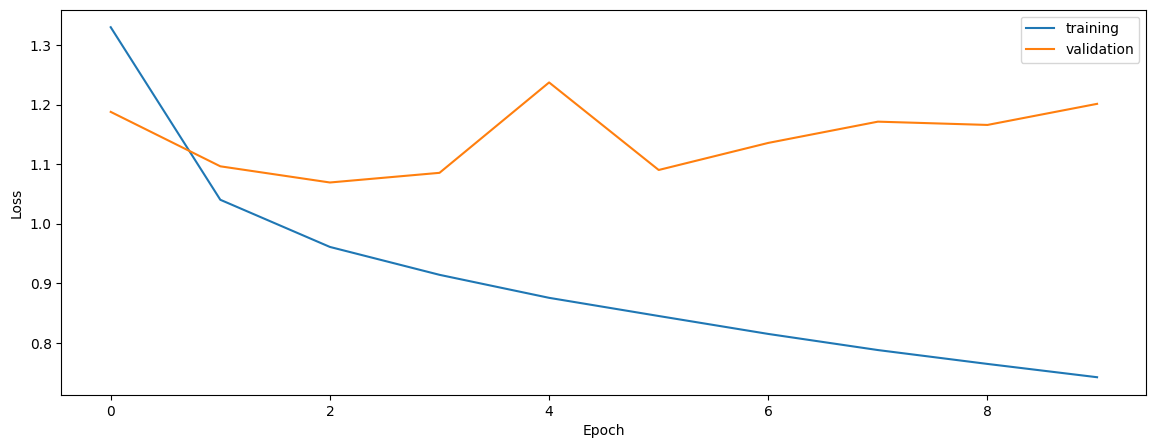

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True
props['collapse_bin'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'BCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_BCE_7_1_0_1_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/126 [..............................] - ETA: 3:26 - loss: 0.6895 - STD: 1.1432e-04 - MAE: 0.4981

  4/126 [..............................] - ETA: 3s - loss: 0.6850 - STD: 5.9954e-04 - MAE: 0.4655  

  7/126 [>.............................] - ETA: 2s - loss: 0.6793 - STD: 0.0014 - MAE: 0.4742    

 10/126 [=>............................] - ETA: 2s - loss: 0.6753 - STD: 0.0020 - MAE: 0.4737

 13/126 [==>...........................] - ETA: 2s - loss: 0.6732 - STD: 0.0028 - MAE: 0.4706

 16/126 [==>...........................] - ETA: 2s - loss: 0.6717 - STD: 0.0038 - MAE: 0.4712

 19/126 [===>..........................] - ETA: 2s - loss: 0.6701 - STD: 0.0053 - MAE: 0.4724

 22/126 [====>.........................] - ETA: 2s - loss: 0.6681 - STD: 0.0071 - MAE: 0.4714

 25/126 [====>.........................] - ETA: 2s - loss: 0.6663 - STD: 0.0100 - MAE: 0.4700

 28/126 [=====>........................] - ETA: 2s - loss: 0.6634 - STD: 0.0146 - MAE: 0.4691

 31/126 [======>.......................] - ETA: 2s - loss: 0.6601 - STD: 0.0209 - MAE: 0.4670

 34/126 [=======>......................] - ETA: 2s - loss: 0.6570 - STD: 0.0292 - MAE: 0.4641

 37/126 [=======>......................] - ETA: 2s - loss: 0.6541 - STD: 0.0391 - MAE: 0.4615

 40/126 [========>.....................] - ETA: 1s - loss: 0.6512 - STD: 0.0480 - MAE: 0.4582

 43/126 [=========>....................] - ETA: 1s - loss: 0.6487 - STD: 0.0556 - MAE: 0.4559

 46/126 [=========>....................] - ETA: 1s - loss: 0.6464 - STD: 0.0611 - MAE: 0.4543

 48/126 [==========>...................] - ETA: 1s - loss: 0.6448 - STD: 0.0641 - MAE: 0.4532

 51/126 [===========>..................] - ETA: 1s - loss: 0.6425 - STD: 0.0693 - MAE: 0.4515

 54/126 [===========>..................] - ETA: 1s - loss: 0.6406 - STD: 0.0749 - MAE: 0.4496

 57/126 [============>.................] - ETA: 1s - loss: 0.6386 - STD: 0.0799 - MAE: 0.4476

 60/126 [=============>................] - ETA: 1s - loss: 0.6367 - STD: 0.0841 - MAE: 0.4462

 63/126 [==============>...............] - ETA: 1s - loss: 0.6352 - STD: 0.0877 - MAE: 0.4449

 66/126 [==============>...............] - ETA: 1s - loss: 0.6335 - STD: 0.0913 - MAE: 0.4436

 69/126 [===============>..............] - ETA: 1s - loss: 0.6319 - STD: 0.0949 - MAE: 0.4422

 72/126 [================>.............] - ETA: 1s - loss: 0.6303 - STD: 0.0982 - MAE: 0.4407

 75/126 [================>.............] - ETA: 1s - loss: 0.6289 - STD: 0.1012 - MAE: 0.4396

 78/126 [=================>............] - ETA: 1s - loss: 0.6273 - STD: 0.1040 - MAE: 0.4383

 81/126 [==================>...........] - ETA: 1s - loss: 0.6256 - STD: 0.1068 - MAE: 0.4369

 84/126 [===================>..........] - ETA: 0s - loss: 0.6240 - STD: 0.1098 - MAE: 0.4355

 87/126 [===================>..........] - ETA: 0s - loss: 0.6226 - STD: 0.1123 - MAE: 0.4343

 90/126 [====================>.........] - ETA: 0s - loss: 0.6212 - STD: 0.1147 - MAE: 0.4332

 93/126 [=====================>........] - ETA: 0s - loss: 0.6197 - STD: 0.1173 - MAE: 0.4319

 94/126 [=====================>........] - ETA: 1s - loss: 0.6194 - STD: 0.1181 - MAE: 0.4314

 97/126 [======================>.......] - ETA: 0s - loss: 0.6180 - STD: 0.1207 - MAE: 0.4301

100/126 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.1229 - MAE: 0.4291

102/126 [=======================>......] - ETA: 0s - loss: 0.6159 - STD: 0.1242 - MAE: 0.4283

105/126 [========================>.....] - ETA: 0s - loss: 0.6147 - STD: 0.1263 - MAE: 0.4272

108/126 [========================>.....] - ETA: 0s - loss: 0.6134 - STD: 0.1285 - MAE: 0.4261

111/126 [=========================>....] - ETA: 0s - loss: 0.6123 - STD: 0.1306 - MAE: 0.4251

114/126 [==========================>...] - ETA: 0s - loss: 0.6113 - STD: 0.1326 - MAE: 0.4242

117/126 [==========================>...] - ETA: 0s - loss: 0.6103 - STD: 0.1342 - MAE: 0.4234

120/126 [===========================>..] - ETA: 0s - loss: 0.6092 - STD: 0.1357 - MAE: 0.4225

123/126 [============================>.] - ETA: 0s - loss: 0.6082 - STD: 0.1375 - MAE: 0.4217

126/126 [==============================] - ETA: 0s - loss: 0.6072 - STD: 0.1393 - MAE: 0.4208

126/126 [==============================] - 6s 36ms/step - loss: 0.6072 - STD: 0.1393 - MAE: 0.4208 - val_loss: 0.5817 - val_STD: 0.1531 - val_MAE: 0.3816


Epoch 2/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5679 - STD: 0.2000 - MAE: 0.3831

  4/126 [..............................] - ETA: 2s - loss: 0.5658 - STD: 0.2044 - MAE: 0.3873

  7/126 [>.............................] - ETA: 2s - loss: 0.5655 - STD: 0.2049 - MAE: 0.3852

 10/126 [=>............................] - ETA: 2s - loss: 0.5663 - STD: 0.2059 - MAE: 0.3847

 13/126 [==>...........................] - ETA: 2s - loss: 0.5657 - STD: 0.2068 - MAE: 0.3847

 16/126 [==>...........................] - ETA: 2s - loss: 0.5651 - STD: 0.2072 - MAE: 0.3844

 19/126 [===>..........................] - ETA: 2s - loss: 0.5650 - STD: 0.2080 - MAE: 0.3843

 22/126 [====>.........................] - ETA: 2s - loss: 0.5643 - STD: 0.2085 - MAE: 0.3835

 25/126 [====>.........................] - ETA: 2s - loss: 0.5642 - STD: 0.2082 - MAE: 0.3832

 28/126 [=====>........................] - ETA: 2s - loss: 0.5636 - STD: 0.2088 - MAE: 0.3830

 31/126 [======>.......................] - ETA: 2s - loss: 0.5634 - STD: 0.2093 - MAE: 0.3829

 34/126 [=======>......................] - ETA: 2s - loss: 0.5632 - STD: 0.2095 - MAE: 0.3829

 37/126 [=======>......................] - ETA: 1s - loss: 0.5626 - STD: 0.2095 - MAE: 0.3827

 40/126 [========>.....................] - ETA: 1s - loss: 0.5628 - STD: 0.2099 - MAE: 0.3826

 43/126 [=========>....................] - ETA: 1s - loss: 0.5624 - STD: 0.2103 - MAE: 0.3821

 46/126 [=========>....................] - ETA: 1s - loss: 0.5621 - STD: 0.2106 - MAE: 0.3819

 49/126 [==========>...................] - ETA: 1s - loss: 0.5616 - STD: 0.2108 - MAE: 0.3817

 52/126 [===========>..................] - ETA: 1s - loss: 0.5611 - STD: 0.2115 - MAE: 0.3813

 55/126 [============>.................] - ETA: 1s - loss: 0.5605 - STD: 0.2121 - MAE: 0.3807

 58/126 [============>.................] - ETA: 1s - loss: 0.5599 - STD: 0.2123 - MAE: 0.3803

 61/126 [=============>................] - ETA: 1s - loss: 0.5595 - STD: 0.2128 - MAE: 0.3800

 64/126 [==============>...............] - ETA: 1s - loss: 0.5589 - STD: 0.2134 - MAE: 0.3794

 67/126 [==============>...............] - ETA: 1s - loss: 0.5588 - STD: 0.2137 - MAE: 0.3790

 70/126 [===============>..............] - ETA: 1s - loss: 0.5584 - STD: 0.2140 - MAE: 0.3787

 73/126 [================>.............] - ETA: 1s - loss: 0.5581 - STD: 0.2143 - MAE: 0.3784

 76/126 [=================>............] - ETA: 1s - loss: 0.5576 - STD: 0.2147 - MAE: 0.3780

 79/126 [=================>............] - ETA: 1s - loss: 0.5572 - STD: 0.2149 - MAE: 0.3778

 82/126 [==================>...........] - ETA: 0s - loss: 0.5568 - STD: 0.2152 - MAE: 0.3775

 85/126 [===================>..........] - ETA: 0s - loss: 0.5564 - STD: 0.2156 - MAE: 0.3772

 88/126 [===================>..........] - ETA: 0s - loss: 0.5558 - STD: 0.2160 - MAE: 0.3768

 91/126 [====================>.........] - ETA: 0s - loss: 0.5557 - STD: 0.2164 - MAE: 0.3765

 94/126 [=====================>........] - ETA: 0s - loss: 0.5551 - STD: 0.2168 - MAE: 0.3760

 97/126 [======================>.......] - ETA: 0s - loss: 0.5546 - STD: 0.2172 - MAE: 0.3756

100/126 [======================>.......] - ETA: 0s - loss: 0.5539 - STD: 0.2176 - MAE: 0.3752

103/126 [=======================>......] - ETA: 0s - loss: 0.5533 - STD: 0.2181 - MAE: 0.3748

106/126 [========================>.....] - ETA: 0s - loss: 0.5531 - STD: 0.2185 - MAE: 0.3742

109/126 [========================>.....] - ETA: 0s - loss: 0.5527 - STD: 0.2190 - MAE: 0.3738

111/126 [=========================>....] - ETA: 0s - loss: 0.5524 - STD: 0.2193 - MAE: 0.3736

114/126 [==========================>...] - ETA: 0s - loss: 0.5522 - STD: 0.2196 - MAE: 0.3732

117/126 [==========================>...] - ETA: 0s - loss: 0.5523 - STD: 0.2198 - MAE: 0.3730

120/126 [===========================>..] - ETA: 0s - loss: 0.5529 - STD: 0.2197 - MAE: 0.3730

123/126 [============================>.] - ETA: 0s - loss: 0.5536 - STD: 0.2197 - MAE: 0.3732

126/126 [==============================] - ETA: 0s - loss: 0.5537 - STD: 0.2190 - MAE: 0.3730

126/126 [==============================] - 3s 25ms/step - loss: 0.5537 - STD: 0.2190 - MAE: 0.3730 - val_loss: 0.5587 - val_STD: 0.1627 - val_MAE: 0.3846


Epoch 3/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5536 - STD: 0.2118 - MAE: 0.3884

  4/126 [..............................] - ETA: 2s - loss: 0.5612 - STD: 0.2036 - MAE: 0.3880

  7/126 [>.............................] - ETA: 2s - loss: 0.5594 - STD: 0.1994 - MAE: 0.3855

 10/126 [=>............................] - ETA: 2s - loss: 0.5573 - STD: 0.2008 - MAE: 0.3844

 13/126 [==>...........................] - ETA: 2s - loss: 0.5548 - STD: 0.2022 - MAE: 0.3821

 16/126 [==>...........................] - ETA: 2s - loss: 0.5531 - STD: 0.2044 - MAE: 0.3806

 19/126 [===>..........................] - ETA: 2s - loss: 0.5509 - STD: 0.2072 - MAE: 0.3792

 22/126 [====>.........................] - ETA: 2s - loss: 0.5484 - STD: 0.2095 - MAE: 0.3766

 25/126 [====>.........................] - ETA: 2s - loss: 0.5470 - STD: 0.2129 - MAE: 0.3744

 28/126 [=====>........................] - ETA: 2s - loss: 0.5450 - STD: 0.2162 - MAE: 0.3723

 31/126 [======>.......................] - ETA: 2s - loss: 0.5437 - STD: 0.2190 - MAE: 0.3704

 34/126 [=======>......................] - ETA: 2s - loss: 0.5428 - STD: 0.2209 - MAE: 0.3690

 37/126 [=======>......................] - ETA: 2s - loss: 0.5417 - STD: 0.2227 - MAE: 0.3674

 40/126 [========>.....................] - ETA: 1s - loss: 0.5409 - STD: 0.2246 - MAE: 0.3662

 43/126 [=========>....................] - ETA: 1s - loss: 0.5401 - STD: 0.2258 - MAE: 0.3652

 46/126 [=========>....................] - ETA: 1s - loss: 0.5392 - STD: 0.2267 - MAE: 0.3646

 49/126 [==========>...................] - ETA: 1s - loss: 0.5385 - STD: 0.2277 - MAE: 0.3639

 52/126 [===========>..................] - ETA: 1s - loss: 0.5377 - STD: 0.2285 - MAE: 0.3631

 55/126 [============>.................] - ETA: 1s - loss: 0.5373 - STD: 0.2291 - MAE: 0.3627

 58/126 [============>.................] - ETA: 1s - loss: 0.5367 - STD: 0.2298 - MAE: 0.3622

 61/126 [=============>................] - ETA: 1s - loss: 0.5362 - STD: 0.2305 - MAE: 0.3616

 64/126 [==============>...............] - ETA: 1s - loss: 0.5355 - STD: 0.2311 - MAE: 0.3610

 67/126 [==============>...............] - ETA: 1s - loss: 0.5352 - STD: 0.2318 - MAE: 0.3607

 70/126 [===============>..............] - ETA: 1s - loss: 0.5346 - STD: 0.2325 - MAE: 0.3601

 73/126 [================>.............] - ETA: 1s - loss: 0.5342 - STD: 0.2332 - MAE: 0.3597

 76/126 [=================>............] - ETA: 1s - loss: 0.5337 - STD: 0.2337 - MAE: 0.3593

 79/126 [=================>............] - ETA: 1s - loss: 0.5335 - STD: 0.2343 - MAE: 0.3588

 82/126 [==================>...........] - ETA: 0s - loss: 0.5332 - STD: 0.2346 - MAE: 0.3586

 85/126 [===================>..........] - ETA: 0s - loss: 0.5329 - STD: 0.2350 - MAE: 0.3582

 88/126 [===================>..........] - ETA: 0s - loss: 0.5323 - STD: 0.2354 - MAE: 0.3577

 91/126 [====================>.........] - ETA: 0s - loss: 0.5321 - STD: 0.2358 - MAE: 0.3574

 94/126 [=====================>........] - ETA: 0s - loss: 0.5319 - STD: 0.2362 - MAE: 0.3571

 97/126 [======================>.......] - ETA: 0s - loss: 0.5320 - STD: 0.2365 - MAE: 0.3568

100/126 [======================>.......] - ETA: 0s - loss: 0.5328 - STD: 0.2365 - MAE: 0.3568

103/126 [=======================>......] - ETA: 0s - loss: 0.5329 - STD: 0.2366 - MAE: 0.3567

106/126 [========================>.....] - ETA: 0s - loss: 0.5330 - STD: 0.2365 - MAE: 0.3568

109/126 [========================>.....] - ETA: 0s - loss: 0.5328 - STD: 0.2361 - MAE: 0.3569

112/126 [=========================>....] - ETA: 0s - loss: 0.5326 - STD: 0.2358 - MAE: 0.3569

115/126 [==========================>...] - ETA: 0s - loss: 0.5324 - STD: 0.2359 - MAE: 0.3569

118/126 [===========================>..] - ETA: 0s - loss: 0.5322 - STD: 0.2359 - MAE: 0.3568

121/126 [===========================>..] - ETA: 0s - loss: 0.5319 - STD: 0.2361 - MAE: 0.3567

124/126 [============================>.] - ETA: 0s - loss: 0.5314 - STD: 0.2363 - MAE: 0.3563

126/126 [==============================] - 3s 25ms/step - loss: 0.5312 - STD: 0.2367 - MAE: 0.3561 - val_loss: 0.5390 - val_STD: 0.2068 - val_MAE: 0.3432


Epoch 4/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5319 - STD: 0.2525 - MAE: 0.3454

  4/126 [..............................] - ETA: 2s - loss: 0.5227 - STD: 0.2563 - MAE: 0.3439

  7/126 [>.............................] - ETA: 2s - loss: 0.5235 - STD: 0.2564 - MAE: 0.3440

 10/126 [=>............................] - ETA: 2s - loss: 0.5218 - STD: 0.2561 - MAE: 0.3434

 13/126 [==>...........................] - ETA: 2s - loss: 0.5203 - STD: 0.2555 - MAE: 0.3426

 16/126 [==>...........................] - ETA: 2s - loss: 0.5189 - STD: 0.2550 - MAE: 0.3420

 19/126 [===>..........................] - ETA: 2s - loss: 0.5186 - STD: 0.2541 - MAE: 0.3423

 22/126 [====>.........................] - ETA: 2s - loss: 0.5187 - STD: 0.2538 - MAE: 0.3427

 25/126 [====>.........................] - ETA: 2s - loss: 0.5184 - STD: 0.2539 - MAE: 0.3427

 28/126 [=====>........................] - ETA: 2s - loss: 0.5185 - STD: 0.2537 - MAE: 0.3430

 31/126 [======>.......................] - ETA: 2s - loss: 0.5179 - STD: 0.2532 - MAE: 0.3430

 34/126 [=======>......................] - ETA: 2s - loss: 0.5188 - STD: 0.2533 - MAE: 0.3431

 37/126 [=======>......................] - ETA: 2s - loss: 0.5197 - STD: 0.2532 - MAE: 0.3434

 40/126 [========>.....................] - ETA: 1s - loss: 0.5200 - STD: 0.2527 - MAE: 0.3437

 43/126 [=========>....................] - ETA: 1s - loss: 0.5199 - STD: 0.2524 - MAE: 0.3438

 46/126 [=========>....................] - ETA: 1s - loss: 0.5200 - STD: 0.2521 - MAE: 0.3441

 49/126 [==========>...................] - ETA: 1s - loss: 0.5201 - STD: 0.2515 - MAE: 0.3444

 51/126 [===========>..................] - ETA: 1s - loss: 0.5198 - STD: 0.2514 - MAE: 0.3445

 54/126 [===========>..................] - ETA: 1s - loss: 0.5195 - STD: 0.2514 - MAE: 0.3444

 57/126 [============>.................] - ETA: 1s - loss: 0.5193 - STD: 0.2515 - MAE: 0.3444

 60/126 [=============>................] - ETA: 1s - loss: 0.5190 - STD: 0.2515 - MAE: 0.3442

 63/126 [==============>...............] - ETA: 1s - loss: 0.5189 - STD: 0.2517 - MAE: 0.3440

 66/126 [==============>...............] - ETA: 1s - loss: 0.5187 - STD: 0.2518 - MAE: 0.3438

 69/126 [===============>..............] - ETA: 1s - loss: 0.5187 - STD: 0.2521 - MAE: 0.3436

 72/126 [================>.............] - ETA: 1s - loss: 0.5185 - STD: 0.2524 - MAE: 0.3435

 75/126 [================>.............] - ETA: 1s - loss: 0.5182 - STD: 0.2524 - MAE: 0.3433

 78/126 [=================>............] - ETA: 1s - loss: 0.5182 - STD: 0.2527 - MAE: 0.3432

 81/126 [==================>...........] - ETA: 1s - loss: 0.5181 - STD: 0.2528 - MAE: 0.3431

 84/126 [===================>..........] - ETA: 0s - loss: 0.5179 - STD: 0.2528 - MAE: 0.3431

 87/126 [===================>..........] - ETA: 0s - loss: 0.5179 - STD: 0.2528 - MAE: 0.3431

 90/126 [====================>.........] - ETA: 0s - loss: 0.5180 - STD: 0.2528 - MAE: 0.3432

 93/126 [=====================>........] - ETA: 0s - loss: 0.5178 - STD: 0.2528 - MAE: 0.3431

 96/126 [=====================>........] - ETA: 0s - loss: 0.5177 - STD: 0.2531 - MAE: 0.3430

 99/126 [======================>.......] - ETA: 0s - loss: 0.5175 - STD: 0.2532 - MAE: 0.3429

102/126 [=======================>......] - ETA: 0s - loss: 0.5175 - STD: 0.2533 - MAE: 0.3428

104/126 [=======================>......] - ETA: 0s - loss: 0.5176 - STD: 0.2533 - MAE: 0.3428

107/126 [========================>.....] - ETA: 0s - loss: 0.5175 - STD: 0.2534 - MAE: 0.3427

110/126 [=========================>....] - ETA: 0s - loss: 0.5173 - STD: 0.2533 - MAE: 0.3426

113/126 [=========================>....] - ETA: 0s - loss: 0.5172 - STD: 0.2534 - MAE: 0.3426

116/126 [==========================>...] - ETA: 0s - loss: 0.5170 - STD: 0.2535 - MAE: 0.3425

119/126 [===========================>..] - ETA: 0s - loss: 0.5168 - STD: 0.2536 - MAE: 0.3424

122/126 [============================>.] - ETA: 0s - loss: 0.5166 - STD: 0.2538 - MAE: 0.3422

125/126 [============================>.] - ETA: 0s - loss: 0.5167 - STD: 0.2538 - MAE: 0.3421

126/126 [==============================] - 3s 25ms/step - loss: 0.5170 - STD: 0.2537 - MAE: 0.3421 - val_loss: 0.5279 - val_STD: 0.2110 - val_MAE: 0.3390


Epoch 5/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5116 - STD: 0.2593 - MAE: 0.3386

  4/126 [..............................] - ETA: 2s - loss: 0.5511 - STD: 0.2403 - MAE: 0.3442

  7/126 [>.............................] - ETA: 2s - loss: 0.5510 - STD: 0.2406 - MAE: 0.3493

 10/126 [=>............................] - ETA: 2s - loss: 0.5439 - STD: 0.2383 - MAE: 0.3534

 13/126 [==>...........................] - ETA: 2s - loss: 0.5410 - STD: 0.2325 - MAE: 0.3555

 16/126 [==>...........................] - ETA: 2s - loss: 0.5378 - STD: 0.2305 - MAE: 0.3562

 19/126 [===>..........................] - ETA: 2s - loss: 0.5353 - STD: 0.2316 - MAE: 0.3564

 22/126 [====>.........................] - ETA: 2s - loss: 0.5336 - STD: 0.2321 - MAE: 0.3558

 25/126 [====>.........................] - ETA: 2s - loss: 0.5321 - STD: 0.2327 - MAE: 0.3551

 28/126 [=====>........................] - ETA: 2s - loss: 0.5299 - STD: 0.2351 - MAE: 0.3536

 31/126 [======>.......................] - ETA: 2s - loss: 0.5280 - STD: 0.2376 - MAE: 0.3520

 34/126 [=======>......................] - ETA: 2s - loss: 0.5265 - STD: 0.2397 - MAE: 0.3506

 37/126 [=======>......................] - ETA: 1s - loss: 0.5252 - STD: 0.2420 - MAE: 0.3493

 40/126 [========>.....................] - ETA: 1s - loss: 0.5241 - STD: 0.2438 - MAE: 0.3481

 43/126 [=========>....................] - ETA: 1s - loss: 0.5234 - STD: 0.2451 - MAE: 0.3472

 46/126 [=========>....................] - ETA: 1s - loss: 0.5225 - STD: 0.2464 - MAE: 0.3463

 49/126 [==========>...................] - ETA: 1s - loss: 0.5217 - STD: 0.2473 - MAE: 0.3457

 52/126 [===========>..................] - ETA: 1s - loss: 0.5207 - STD: 0.2477 - MAE: 0.3451

 55/126 [============>.................] - ETA: 1s - loss: 0.5197 - STD: 0.2484 - MAE: 0.3445

 58/126 [============>.................] - ETA: 1s - loss: 0.5191 - STD: 0.2489 - MAE: 0.3441

 61/126 [=============>................] - ETA: 1s - loss: 0.5189 - STD: 0.2493 - MAE: 0.3439

 64/126 [==============>...............] - ETA: 1s - loss: 0.5183 - STD: 0.2498 - MAE: 0.3434

 67/126 [==============>...............] - ETA: 1s - loss: 0.5179 - STD: 0.2502 - MAE: 0.3431

 70/126 [===============>..............] - ETA: 1s - loss: 0.5173 - STD: 0.2506 - MAE: 0.3427

 73/126 [================>.............] - ETA: 1s - loss: 0.5171 - STD: 0.2510 - MAE: 0.3424

 76/126 [=================>............] - ETA: 1s - loss: 0.5169 - STD: 0.2512 - MAE: 0.3422

 79/126 [=================>............] - ETA: 1s - loss: 0.5168 - STD: 0.2516 - MAE: 0.3420

 82/126 [==================>...........] - ETA: 0s - loss: 0.5166 - STD: 0.2518 - MAE: 0.3418

 85/126 [===================>..........] - ETA: 0s - loss: 0.5164 - STD: 0.2519 - MAE: 0.3417

 88/126 [===================>..........] - ETA: 0s - loss: 0.5164 - STD: 0.2521 - MAE: 0.3416

 91/126 [====================>.........] - ETA: 0s - loss: 0.5162 - STD: 0.2523 - MAE: 0.3415

 94/126 [=====================>........] - ETA: 0s - loss: 0.5160 - STD: 0.2525 - MAE: 0.3414

 97/126 [======================>.......] - ETA: 0s - loss: 0.5158 - STD: 0.2525 - MAE: 0.3414

100/126 [======================>.......] - ETA: 0s - loss: 0.5158 - STD: 0.2526 - MAE: 0.3413

103/126 [=======================>......] - ETA: 0s - loss: 0.5156 - STD: 0.2527 - MAE: 0.3412

106/126 [========================>.....] - ETA: 0s - loss: 0.5154 - STD: 0.2530 - MAE: 0.3411

109/126 [========================>.....] - ETA: 0s - loss: 0.5153 - STD: 0.2531 - MAE: 0.3410

112/126 [=========================>....] - ETA: 0s - loss: 0.5151 - STD: 0.2534 - MAE: 0.3408

115/126 [==========================>...] - ETA: 0s - loss: 0.5148 - STD: 0.2536 - MAE: 0.3406

118/126 [===========================>..] - ETA: 0s - loss: 0.5147 - STD: 0.2538 - MAE: 0.3405

121/126 [===========================>..] - ETA: 0s - loss: 0.5146 - STD: 0.2539 - MAE: 0.3405

124/126 [============================>.] - ETA: 0s - loss: 0.5145 - STD: 0.2541 - MAE: 0.3404

126/126 [==============================] - 3s 25ms/step - loss: 0.5145 - STD: 0.2541 - MAE: 0.3403 - val_loss: 0.5301 - val_STD: 0.2253 - val_MAE: 0.3440


Epoch 6/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5159 - STD: 0.2674 - MAE: 0.3422

  3/126 [..............................] - ETA: 3s - loss: 0.5147 - STD: 0.2612 - MAE: 0.3391

  6/126 [>.............................] - ETA: 2s - loss: 0.5152 - STD: 0.2570 - MAE: 0.3384

  9/126 [=>............................] - ETA: 2s - loss: 0.5184 - STD: 0.2557 - MAE: 0.3385

 12/126 [=>............................] - ETA: 2s - loss: 0.5176 - STD: 0.2549 - MAE: 0.3389

 15/126 [==>...........................] - ETA: 2s - loss: 0.5162 - STD: 0.2538 - MAE: 0.3396

 18/126 [===>..........................] - ETA: 2s - loss: 0.5151 - STD: 0.2539 - MAE: 0.3401

 21/126 [====>.........................] - ETA: 2s - loss: 0.5141 - STD: 0.2539 - MAE: 0.3400

 24/126 [====>.........................] - ETA: 2s - loss: 0.5130 - STD: 0.2539 - MAE: 0.3396

 27/126 [=====>........................] - ETA: 2s - loss: 0.5124 - STD: 0.2546 - MAE: 0.3392

 30/126 [======>.......................] - ETA: 2s - loss: 0.5115 - STD: 0.2553 - MAE: 0.3385

 33/126 [======>.......................] - ETA: 2s - loss: 0.5110 - STD: 0.2560 - MAE: 0.3379

 36/126 [=======>......................] - ETA: 2s - loss: 0.5107 - STD: 0.2566 - MAE: 0.3375

 39/126 [========>.....................] - ETA: 1s - loss: 0.5103 - STD: 0.2575 - MAE: 0.3370

 42/126 [=========>....................] - ETA: 1s - loss: 0.5098 - STD: 0.2580 - MAE: 0.3366

 45/126 [=========>....................] - ETA: 1s - loss: 0.5096 - STD: 0.2585 - MAE: 0.3363

 48/126 [==========>...................] - ETA: 1s - loss: 0.5097 - STD: 0.2588 - MAE: 0.3363

 51/126 [===========>..................] - ETA: 1s - loss: 0.5093 - STD: 0.2591 - MAE: 0.3360

 54/126 [===========>..................] - ETA: 1s - loss: 0.5091 - STD: 0.2593 - MAE: 0.3358

 57/126 [============>.................] - ETA: 1s - loss: 0.5090 - STD: 0.2592 - MAE: 0.3358

 60/126 [=============>................] - ETA: 1s - loss: 0.5091 - STD: 0.2591 - MAE: 0.3357

 63/126 [==============>...............] - ETA: 1s - loss: 0.5092 - STD: 0.2591 - MAE: 0.3357

 66/126 [==============>...............] - ETA: 1s - loss: 0.5094 - STD: 0.2590 - MAE: 0.3359

 69/126 [===============>..............] - ETA: 1s - loss: 0.5092 - STD: 0.2590 - MAE: 0.3359

 72/126 [================>.............] - ETA: 1s - loss: 0.5090 - STD: 0.2590 - MAE: 0.3359

 75/126 [================>.............] - ETA: 1s - loss: 0.5090 - STD: 0.2591 - MAE: 0.3359

 78/126 [=================>............] - ETA: 1s - loss: 0.5090 - STD: 0.2592 - MAE: 0.3358

 81/126 [==================>...........] - ETA: 1s - loss: 0.5090 - STD: 0.2593 - MAE: 0.3359

 84/126 [===================>..........] - ETA: 0s - loss: 0.5090 - STD: 0.2594 - MAE: 0.3359

 87/126 [===================>..........] - ETA: 0s - loss: 0.5092 - STD: 0.2593 - MAE: 0.3359

 90/126 [====================>.........] - ETA: 0s - loss: 0.5091 - STD: 0.2593 - MAE: 0.3359

 93/126 [=====================>........] - ETA: 0s - loss: 0.5092 - STD: 0.2592 - MAE: 0.3359

 96/126 [=====================>........] - ETA: 0s - loss: 0.5091 - STD: 0.2591 - MAE: 0.3359

 99/126 [======================>.......] - ETA: 0s - loss: 0.5090 - STD: 0.2591 - MAE: 0.3359

102/126 [=======================>......] - ETA: 0s - loss: 0.5089 - STD: 0.2591 - MAE: 0.3358

105/126 [========================>.....] - ETA: 0s - loss: 0.5089 - STD: 0.2592 - MAE: 0.3358

108/126 [========================>.....] - ETA: 0s - loss: 0.5089 - STD: 0.2593 - MAE: 0.3358

111/126 [=========================>....] - ETA: 0s - loss: 0.5088 - STD: 0.2594 - MAE: 0.3357

114/126 [==========================>...] - ETA: 0s - loss: 0.5087 - STD: 0.2595 - MAE: 0.3356

117/126 [==========================>...] - ETA: 0s - loss: 0.5086 - STD: 0.2596 - MAE: 0.3356

120/126 [===========================>..] - ETA: 0s - loss: 0.5085 - STD: 0.2596 - MAE: 0.3356

123/126 [============================>.] - ETA: 0s - loss: 0.5085 - STD: 0.2597 - MAE: 0.3355

126/126 [==============================] - ETA: 0s - loss: 0.5085 - STD: 0.2598 - MAE: 0.3355

126/126 [==============================] - 3s 25ms/step - loss: 0.5085 - STD: 0.2598 - MAE: 0.3355 - val_loss: 0.5242 - val_STD: 0.2009 - val_MAE: 0.3307


Epoch 7/10000


  1/126 [..............................] - ETA: 7s - loss: 0.5076 - STD: 0.2481 - MAE: 0.3291

  4/126 [..............................] - ETA: 2s - loss: 0.5113 - STD: 0.2567 - MAE: 0.3347

  7/126 [>.............................] - ETA: 2s - loss: 0.5102 - STD: 0.2578 - MAE: 0.3345

 10/126 [=>............................] - ETA: 2s - loss: 0.5106 - STD: 0.2574 - MAE: 0.3352

 13/126 [==>...........................] - ETA: 2s - loss: 0.5104 - STD: 0.2581 - MAE: 0.3357

 16/126 [==>...........................] - ETA: 2s - loss: 0.5103 - STD: 0.2572 - MAE: 0.3364

 19/126 [===>..........................] - ETA: 2s - loss: 0.5099 - STD: 0.2571 - MAE: 0.3366

 22/126 [====>.........................] - ETA: 2s - loss: 0.5087 - STD: 0.2574 - MAE: 0.3359

 25/126 [====>.........................] - ETA: 2s - loss: 0.5083 - STD: 0.2577 - MAE: 0.3357

 28/126 [=====>........................] - ETA: 2s - loss: 0.5080 - STD: 0.2579 - MAE: 0.3352

 31/126 [======>.......................] - ETA: 2s - loss: 0.5087 - STD: 0.2583 - MAE: 0.3349

 34/126 [=======>......................] - ETA: 2s - loss: 0.5086 - STD: 0.2588 - MAE: 0.3347

 37/126 [=======>......................] - ETA: 1s - loss: 0.5087 - STD: 0.2589 - MAE: 0.3349

 40/126 [========>.....................] - ETA: 1s - loss: 0.5084 - STD: 0.2590 - MAE: 0.3349

 42/126 [=========>....................] - ETA: 1s - loss: 0.5080 - STD: 0.2590 - MAE: 0.3349

 45/126 [=========>....................] - ETA: 1s - loss: 0.5073 - STD: 0.2591 - MAE: 0.3346

 48/126 [==========>...................] - ETA: 1s - loss: 0.5068 - STD: 0.2593 - MAE: 0.3344

 51/126 [===========>..................] - ETA: 1s - loss: 0.5065 - STD: 0.2595 - MAE: 0.3342

 54/126 [===========>..................] - ETA: 1s - loss: 0.5064 - STD: 0.2600 - MAE: 0.3341

 57/126 [============>.................] - ETA: 1s - loss: 0.5062 - STD: 0.2605 - MAE: 0.3338

 60/126 [=============>................] - ETA: 1s - loss: 0.5062 - STD: 0.2609 - MAE: 0.3336

 63/126 [==============>...............] - ETA: 1s - loss: 0.5060 - STD: 0.2611 - MAE: 0.3335

 66/126 [==============>...............] - ETA: 1s - loss: 0.5060 - STD: 0.2612 - MAE: 0.3335

 69/126 [===============>..............] - ETA: 1s - loss: 0.5059 - STD: 0.2614 - MAE: 0.3334

 72/126 [================>.............] - ETA: 1s - loss: 0.5058 - STD: 0.2614 - MAE: 0.3334

 75/126 [================>.............] - ETA: 1s - loss: 0.5059 - STD: 0.2615 - MAE: 0.3333

 78/126 [=================>............] - ETA: 1s - loss: 0.5059 - STD: 0.2615 - MAE: 0.3333

 81/126 [==================>...........] - ETA: 1s - loss: 0.5065 - STD: 0.2614 - MAE: 0.3334

 84/126 [===================>..........] - ETA: 0s - loss: 0.5065 - STD: 0.2610 - MAE: 0.3334

 87/126 [===================>..........] - ETA: 0s - loss: 0.5068 - STD: 0.2606 - MAE: 0.3336

 90/126 [====================>.........] - ETA: 0s - loss: 0.5071 - STD: 0.2604 - MAE: 0.3338

 93/126 [=====================>........] - ETA: 0s - loss: 0.5070 - STD: 0.2601 - MAE: 0.3340

 96/126 [=====================>........] - ETA: 0s - loss: 0.5071 - STD: 0.2599 - MAE: 0.3342

 99/126 [======================>.......] - ETA: 0s - loss: 0.5073 - STD: 0.2596 - MAE: 0.3343

102/126 [=======================>......] - ETA: 0s - loss: 0.5073 - STD: 0.2595 - MAE: 0.3343

105/126 [========================>.....] - ETA: 0s - loss: 0.5073 - STD: 0.2594 - MAE: 0.3343

108/126 [========================>.....] - ETA: 0s - loss: 0.5070 - STD: 0.2597 - MAE: 0.3342

111/126 [=========================>....] - ETA: 0s - loss: 0.5068 - STD: 0.2598 - MAE: 0.3341

114/126 [==========================>...] - ETA: 0s - loss: 0.5067 - STD: 0.2601 - MAE: 0.3340

117/126 [==========================>...] - ETA: 0s - loss: 0.5067 - STD: 0.2602 - MAE: 0.3339

120/126 [===========================>..] - ETA: 0s - loss: 0.5066 - STD: 0.2603 - MAE: 0.3338

123/126 [============================>.] - ETA: 0s - loss: 0.5065 - STD: 0.2605 - MAE: 0.3337

126/126 [==============================] - ETA: 0s - loss: 0.5065 - STD: 0.2606 - MAE: 0.3337

126/126 [==============================] - 3s 25ms/step - loss: 0.5065 - STD: 0.2606 - MAE: 0.3337 - val_loss: 0.5159 - val_STD: 0.2191 - val_MAE: 0.3313


Epoch 8/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5101 - STD: 0.2657 - MAE: 0.3347

  4/126 [..............................] - ETA: 2s - loss: 0.5019 - STD: 0.2637 - MAE: 0.3315

  7/126 [>.............................] - ETA: 2s - loss: 0.5021 - STD: 0.2642 - MAE: 0.3319

 10/126 [=>............................] - ETA: 2s - loss: 0.5011 - STD: 0.2659 - MAE: 0.3311

 13/126 [==>...........................] - ETA: 2s - loss: 0.5004 - STD: 0.2659 - MAE: 0.3308

 16/126 [==>...........................] - ETA: 2s - loss: 0.5006 - STD: 0.2655 - MAE: 0.3304

 19/126 [===>..........................] - ETA: 2s - loss: 0.5012 - STD: 0.2647 - MAE: 0.3303

 22/126 [====>.........................] - ETA: 2s - loss: 0.5032 - STD: 0.2642 - MAE: 0.3305

 25/126 [====>.........................] - ETA: 2s - loss: 0.5042 - STD: 0.2633 - MAE: 0.3308

 28/126 [=====>........................] - ETA: 2s - loss: 0.5051 - STD: 0.2627 - MAE: 0.3317

 31/126 [======>.......................] - ETA: 2s - loss: 0.5050 - STD: 0.2627 - MAE: 0.3321

 34/126 [=======>......................] - ETA: 2s - loss: 0.5052 - STD: 0.2620 - MAE: 0.3326

 37/126 [=======>......................] - ETA: 2s - loss: 0.5048 - STD: 0.2614 - MAE: 0.3326

 40/126 [========>.....................] - ETA: 1s - loss: 0.5047 - STD: 0.2614 - MAE: 0.3328

 43/126 [=========>....................] - ETA: 1s - loss: 0.5045 - STD: 0.2616 - MAE: 0.3325

 46/126 [=========>....................] - ETA: 1s - loss: 0.5043 - STD: 0.2618 - MAE: 0.3322

 49/126 [==========>...................] - ETA: 1s - loss: 0.5044 - STD: 0.2623 - MAE: 0.3322

 52/126 [===========>..................] - ETA: 1s - loss: 0.5041 - STD: 0.2626 - MAE: 0.3320

 55/126 [============>.................] - ETA: 1s - loss: 0.5037 - STD: 0.2627 - MAE: 0.3318

 58/126 [============>.................] - ETA: 1s - loss: 0.5033 - STD: 0.2630 - MAE: 0.3315

 61/126 [=============>................] - ETA: 1s - loss: 0.5030 - STD: 0.2634 - MAE: 0.3314

 64/126 [==============>...............] - ETA: 1s - loss: 0.5029 - STD: 0.2638 - MAE: 0.3312

 67/126 [==============>...............] - ETA: 1s - loss: 0.5027 - STD: 0.2639 - MAE: 0.3311

 70/126 [===============>..............] - ETA: 1s - loss: 0.5025 - STD: 0.2641 - MAE: 0.3309

 73/126 [================>.............] - ETA: 1s - loss: 0.5021 - STD: 0.2643 - MAE: 0.3306

 76/126 [=================>............] - ETA: 1s - loss: 0.5023 - STD: 0.2643 - MAE: 0.3306

 79/126 [=================>............] - ETA: 1s - loss: 0.5023 - STD: 0.2644 - MAE: 0.3305

 82/126 [==================>...........] - ETA: 1s - loss: 0.5022 - STD: 0.2645 - MAE: 0.3305

 85/126 [===================>..........] - ETA: 0s - loss: 0.5022 - STD: 0.2645 - MAE: 0.3306

 88/126 [===================>..........] - ETA: 0s - loss: 0.5021 - STD: 0.2646 - MAE: 0.3305

 91/126 [====================>.........] - ETA: 0s - loss: 0.5021 - STD: 0.2646 - MAE: 0.3305

 94/126 [=====================>........] - ETA: 0s - loss: 0.5020 - STD: 0.2648 - MAE: 0.3304

 97/126 [======================>.......] - ETA: 0s - loss: 0.5020 - STD: 0.2648 - MAE: 0.3304

100/126 [======================>.......] - ETA: 0s - loss: 0.5019 - STD: 0.2648 - MAE: 0.3304

103/126 [=======================>......] - ETA: 0s - loss: 0.5019 - STD: 0.2648 - MAE: 0.3303

106/126 [========================>.....] - ETA: 0s - loss: 0.5018 - STD: 0.2647 - MAE: 0.3303

109/126 [========================>.....] - ETA: 0s - loss: 0.5019 - STD: 0.2648 - MAE: 0.3303

112/126 [=========================>....] - ETA: 0s - loss: 0.5017 - STD: 0.2649 - MAE: 0.3303

114/126 [==========================>...] - ETA: 0s - loss: 0.5015 - STD: 0.2650 - MAE: 0.3302

117/126 [==========================>...] - ETA: 0s - loss: 0.5015 - STD: 0.2650 - MAE: 0.3301

120/126 [===========================>..] - ETA: 0s - loss: 0.5013 - STD: 0.2652 - MAE: 0.3300

123/126 [============================>.] - ETA: 0s - loss: 0.5012 - STD: 0.2653 - MAE: 0.3299

126/126 [==============================] - ETA: 0s - loss: 0.5012 - STD: 0.2654 - MAE: 0.3299

126/126 [==============================] - 3s 25ms/step - loss: 0.5012 - STD: 0.2654 - MAE: 0.3299 - val_loss: 0.5126 - val_STD: 0.2262 - val_MAE: 0.3286


Epoch 9/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4991 - STD: 0.2689 - MAE: 0.3292

  4/126 [..............................] - ETA: 2s - loss: 0.4976 - STD: 0.2682 - MAE: 0.3278

  7/126 [>.............................] - ETA: 2s - loss: 0.4969 - STD: 0.2682 - MAE: 0.3268

 10/126 [=>............................] - ETA: 2s - loss: 0.4974 - STD: 0.2683 - MAE: 0.3267

 13/126 [==>...........................] - ETA: 2s - loss: 0.4980 - STD: 0.2685 - MAE: 0.3270

 16/126 [==>...........................] - ETA: 2s - loss: 0.4972 - STD: 0.2687 - MAE: 0.3267

 19/126 [===>..........................] - ETA: 2s - loss: 0.4970 - STD: 0.2683 - MAE: 0.3269

 22/126 [====>.........................] - ETA: 2s - loss: 0.4982 - STD: 0.2687 - MAE: 0.3271

 25/126 [====>.........................] - ETA: 2s - loss: 0.4984 - STD: 0.2682 - MAE: 0.3273

 28/126 [=====>........................] - ETA: 2s - loss: 0.4985 - STD: 0.2682 - MAE: 0.3273

 31/126 [======>.......................] - ETA: 2s - loss: 0.4989 - STD: 0.2683 - MAE: 0.3276

 34/126 [=======>......................] - ETA: 2s - loss: 0.4988 - STD: 0.2675 - MAE: 0.3280

 37/126 [=======>......................] - ETA: 2s - loss: 0.4990 - STD: 0.2680 - MAE: 0.3279

 40/126 [========>.....................] - ETA: 1s - loss: 0.4993 - STD: 0.2676 - MAE: 0.3282

 43/126 [=========>....................] - ETA: 1s - loss: 0.4993 - STD: 0.2676 - MAE: 0.3281

 46/126 [=========>....................] - ETA: 1s - loss: 0.4992 - STD: 0.2676 - MAE: 0.3281

 49/126 [==========>...................] - ETA: 1s - loss: 0.4995 - STD: 0.2674 - MAE: 0.3281

 52/126 [===========>..................] - ETA: 1s - loss: 0.4995 - STD: 0.2673 - MAE: 0.3282

 55/126 [============>.................] - ETA: 1s - loss: 0.4999 - STD: 0.2668 - MAE: 0.3284

 58/126 [============>.................] - ETA: 1s - loss: 0.5003 - STD: 0.2665 - MAE: 0.3286

 61/126 [=============>................] - ETA: 1s - loss: 0.5003 - STD: 0.2663 - MAE: 0.3287

 64/126 [==============>...............] - ETA: 1s - loss: 0.5003 - STD: 0.2661 - MAE: 0.3288

 67/126 [==============>...............] - ETA: 1s - loss: 0.5001 - STD: 0.2662 - MAE: 0.3287

 70/126 [===============>..............] - ETA: 1s - loss: 0.4999 - STD: 0.2663 - MAE: 0.3287

 73/126 [================>.............] - ETA: 1s - loss: 0.4996 - STD: 0.2666 - MAE: 0.3284

 76/126 [=================>............] - ETA: 1s - loss: 0.4995 - STD: 0.2667 - MAE: 0.3283

 79/126 [=================>............] - ETA: 1s - loss: 0.4996 - STD: 0.2667 - MAE: 0.3284

 82/126 [==================>...........] - ETA: 1s - loss: 0.4993 - STD: 0.2668 - MAE: 0.3283

 85/126 [===================>..........] - ETA: 0s - loss: 0.4991 - STD: 0.2668 - MAE: 0.3282

 88/126 [===================>..........] - ETA: 0s - loss: 0.4990 - STD: 0.2671 - MAE: 0.3281

 91/126 [====================>.........] - ETA: 0s - loss: 0.4987 - STD: 0.2672 - MAE: 0.3279

 94/126 [=====================>........] - ETA: 0s - loss: 0.4987 - STD: 0.2674 - MAE: 0.3279

 97/126 [======================>.......] - ETA: 0s - loss: 0.4984 - STD: 0.2675 - MAE: 0.3277

100/126 [======================>.......] - ETA: 0s - loss: 0.4982 - STD: 0.2676 - MAE: 0.3276

103/126 [=======================>......] - ETA: 0s - loss: 0.4982 - STD: 0.2678 - MAE: 0.3276

105/126 [========================>.....] - ETA: 0s - loss: 0.4981 - STD: 0.2679 - MAE: 0.3275

108/126 [========================>.....] - ETA: 0s - loss: 0.4978 - STD: 0.2681 - MAE: 0.3273

111/126 [=========================>....] - ETA: 0s - loss: 0.4978 - STD: 0.2683 - MAE: 0.3272

114/126 [==========================>...] - ETA: 0s - loss: 0.4976 - STD: 0.2684 - MAE: 0.3271

117/126 [==========================>...] - ETA: 0s - loss: 0.4975 - STD: 0.2684 - MAE: 0.3270

120/126 [===========================>..] - ETA: 0s - loss: 0.4975 - STD: 0.2684 - MAE: 0.3270

123/126 [============================>.] - ETA: 0s - loss: 0.4974 - STD: 0.2684 - MAE: 0.3269

126/126 [==============================] - ETA: 0s - loss: 0.4974 - STD: 0.2684 - MAE: 0.3269

126/126 [==============================] - 3s 25ms/step - loss: 0.4974 - STD: 0.2684 - MAE: 0.3269 - val_loss: 0.5101 - val_STD: 0.2309 - val_MAE: 0.3310


Epoch 10/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4944 - STD: 0.2693 - MAE: 0.3298

  4/126 [..............................] - ETA: 2s - loss: 0.4968 - STD: 0.2696 - MAE: 0.3286

  7/126 [>.............................] - ETA: 2s - loss: 0.4952 - STD: 0.2715 - MAE: 0.3259

 10/126 [=>............................] - ETA: 2s - loss: 0.4953 - STD: 0.2697 - MAE: 0.3257

 13/126 [==>...........................] - ETA: 2s - loss: 0.4937 - STD: 0.2713 - MAE: 0.3244

 16/126 [==>...........................] - ETA: 2s - loss: 0.4945 - STD: 0.2707 - MAE: 0.3247

 19/126 [===>..........................] - ETA: 2s - loss: 0.4936 - STD: 0.2714 - MAE: 0.3243

 22/126 [====>.........................] - ETA: 2s - loss: 0.4932 - STD: 0.2715 - MAE: 0.3240

 25/126 [====>.........................] - ETA: 2s - loss: 0.4938 - STD: 0.2715 - MAE: 0.3243

 28/126 [=====>........................] - ETA: 2s - loss: 0.4939 - STD: 0.2713 - MAE: 0.3244

 31/126 [======>.......................] - ETA: 2s - loss: 0.4941 - STD: 0.2708 - MAE: 0.3247

 34/126 [=======>......................] - ETA: 2s - loss: 0.4938 - STD: 0.2713 - MAE: 0.3244

 37/126 [=======>......................] - ETA: 2s - loss: 0.4934 - STD: 0.2714 - MAE: 0.3242

 40/126 [========>.....................] - ETA: 1s - loss: 0.4935 - STD: 0.2715 - MAE: 0.3242

 43/126 [=========>....................] - ETA: 1s - loss: 0.4936 - STD: 0.2711 - MAE: 0.3244

 46/126 [=========>....................] - ETA: 1s - loss: 0.4933 - STD: 0.2712 - MAE: 0.3243

 49/126 [==========>...................] - ETA: 1s - loss: 0.4938 - STD: 0.2713 - MAE: 0.3243

 52/126 [===========>..................] - ETA: 1s - loss: 0.4942 - STD: 0.2714 - MAE: 0.3244

 55/126 [============>.................] - ETA: 1s - loss: 0.4942 - STD: 0.2711 - MAE: 0.3246

 58/126 [============>.................] - ETA: 1s - loss: 0.4944 - STD: 0.2710 - MAE: 0.3247

 61/126 [=============>................] - ETA: 1s - loss: 0.4948 - STD: 0.2707 - MAE: 0.3248

 64/126 [==============>...............] - ETA: 1s - loss: 0.4951 - STD: 0.2705 - MAE: 0.3249

 67/126 [==============>...............] - ETA: 1s - loss: 0.4951 - STD: 0.2702 - MAE: 0.3251

 70/126 [===============>..............] - ETA: 1s - loss: 0.4950 - STD: 0.2700 - MAE: 0.3251

 73/126 [================>.............] - ETA: 1s - loss: 0.4951 - STD: 0.2701 - MAE: 0.3251

 76/126 [=================>............] - ETA: 1s - loss: 0.4950 - STD: 0.2701 - MAE: 0.3251

 79/126 [=================>............] - ETA: 1s - loss: 0.4948 - STD: 0.2702 - MAE: 0.3249

 82/126 [==================>...........] - ETA: 1s - loss: 0.4947 - STD: 0.2702 - MAE: 0.3249

 85/126 [===================>..........] - ETA: 0s - loss: 0.4946 - STD: 0.2702 - MAE: 0.3249

 88/126 [===================>..........] - ETA: 0s - loss: 0.4945 - STD: 0.2702 - MAE: 0.3248

 91/126 [====================>.........] - ETA: 0s - loss: 0.4945 - STD: 0.2702 - MAE: 0.3248

 94/126 [=====================>........] - ETA: 0s - loss: 0.4943 - STD: 0.2703 - MAE: 0.3248

 97/126 [======================>.......] - ETA: 0s - loss: 0.4941 - STD: 0.2704 - MAE: 0.3247

100/126 [======================>.......] - ETA: 0s - loss: 0.4941 - STD: 0.2706 - MAE: 0.3245

103/126 [=======================>......] - ETA: 0s - loss: 0.4938 - STD: 0.2708 - MAE: 0.3243

106/126 [========================>.....] - ETA: 0s - loss: 0.4936 - STD: 0.2708 - MAE: 0.3242

109/126 [========================>.....] - ETA: 0s - loss: 0.4934 - STD: 0.2708 - MAE: 0.3241

112/126 [=========================>....] - ETA: 0s - loss: 0.4934 - STD: 0.2710 - MAE: 0.3241

115/126 [==========================>...] - ETA: 0s - loss: 0.4932 - STD: 0.2711 - MAE: 0.3240

118/126 [===========================>..] - ETA: 0s - loss: 0.4931 - STD: 0.2712 - MAE: 0.3238

121/126 [===========================>..] - ETA: 0s - loss: 0.4930 - STD: 0.2713 - MAE: 0.3238

124/126 [============================>.] - ETA: 0s - loss: 0.4930 - STD: 0.2713 - MAE: 0.3237

126/126 [==============================] - 3s 25ms/step - loss: 0.4931 - STD: 0.2713 - MAE: 0.3237 - val_loss: 0.5064 - val_STD: 0.2294 - val_MAE: 0.3240


Epoch 11/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4861 - STD: 0.2773 - MAE: 0.3212

  4/126 [..............................] - ETA: 2s - loss: 0.5026 - STD: 0.2696 - MAE: 0.3245

  6/126 [>.............................] - ETA: 3s - loss: 0.5107 - STD: 0.2644 - MAE: 0.3276

  9/126 [=>............................] - ETA: 2s - loss: 0.5206 - STD: 0.2591 - MAE: 0.3317

 12/126 [=>............................] - ETA: 2s - loss: 0.5234 - STD: 0.2554 - MAE: 0.3365

 15/126 [==>...........................] - ETA: 2s - loss: 0.5265 - STD: 0.2493 - MAE: 0.3396

 18/126 [===>..........................] - ETA: 2s - loss: 0.5241 - STD: 0.2477 - MAE: 0.3395

 21/126 [====>.........................] - ETA: 2s - loss: 0.5227 - STD: 0.2497 - MAE: 0.3394

 24/126 [====>.........................] - ETA: 2s - loss: 0.5219 - STD: 0.2501 - MAE: 0.3395

 27/126 [=====>........................] - ETA: 2s - loss: 0.5200 - STD: 0.2501 - MAE: 0.3385

 30/126 [======>.......................] - ETA: 2s - loss: 0.5191 - STD: 0.2504 - MAE: 0.3384

 33/126 [======>.......................] - ETA: 2s - loss: 0.5178 - STD: 0.2508 - MAE: 0.3387

 36/126 [=======>......................] - ETA: 2s - loss: 0.5167 - STD: 0.2513 - MAE: 0.3384

 39/126 [========>.....................] - ETA: 2s - loss: 0.5149 - STD: 0.2515 - MAE: 0.3377

 42/126 [=========>....................] - ETA: 1s - loss: 0.5136 - STD: 0.2523 - MAE: 0.3372

 45/126 [=========>....................] - ETA: 1s - loss: 0.5120 - STD: 0.2536 - MAE: 0.3363

 48/126 [==========>...................] - ETA: 1s - loss: 0.5108 - STD: 0.2546 - MAE: 0.3355

 51/126 [===========>..................] - ETA: 1s - loss: 0.5097 - STD: 0.2556 - MAE: 0.3348

 54/126 [===========>..................] - ETA: 1s - loss: 0.5083 - STD: 0.2566 - MAE: 0.3339

 57/126 [============>.................] - ETA: 1s - loss: 0.5072 - STD: 0.2575 - MAE: 0.3333

 60/126 [=============>................] - ETA: 1s - loss: 0.5063 - STD: 0.2583 - MAE: 0.3328

 63/126 [==============>...............] - ETA: 1s - loss: 0.5052 - STD: 0.2590 - MAE: 0.3322

 66/126 [==============>...............] - ETA: 1s - loss: 0.5046 - STD: 0.2597 - MAE: 0.3317

 69/126 [===============>..............] - ETA: 1s - loss: 0.5040 - STD: 0.2603 - MAE: 0.3314

 72/126 [================>.............] - ETA: 1s - loss: 0.5034 - STD: 0.2609 - MAE: 0.3310

 75/126 [================>.............] - ETA: 1s - loss: 0.5028 - STD: 0.2614 - MAE: 0.3306

 78/126 [=================>............] - ETA: 1s - loss: 0.5021 - STD: 0.2618 - MAE: 0.3301

 81/126 [==================>...........] - ETA: 1s - loss: 0.5019 - STD: 0.2624 - MAE: 0.3298

 84/126 [===================>..........] - ETA: 0s - loss: 0.5016 - STD: 0.2628 - MAE: 0.3296

 87/126 [===================>..........] - ETA: 0s - loss: 0.5011 - STD: 0.2631 - MAE: 0.3293

 90/126 [====================>.........] - ETA: 0s - loss: 0.5007 - STD: 0.2635 - MAE: 0.3290

 93/126 [=====================>........] - ETA: 0s - loss: 0.5005 - STD: 0.2637 - MAE: 0.3289

 96/126 [=====================>........] - ETA: 0s - loss: 0.5003 - STD: 0.2642 - MAE: 0.3286

 99/126 [======================>.......] - ETA: 0s - loss: 0.4999 - STD: 0.2643 - MAE: 0.3284

102/126 [=======================>......] - ETA: 0s - loss: 0.4996 - STD: 0.2647 - MAE: 0.3282

105/126 [========================>.....] - ETA: 0s - loss: 0.4992 - STD: 0.2649 - MAE: 0.3280

108/126 [========================>.....] - ETA: 0s - loss: 0.4989 - STD: 0.2652 - MAE: 0.3278

111/126 [=========================>....] - ETA: 0s - loss: 0.4986 - STD: 0.2655 - MAE: 0.3276

114/126 [==========================>...] - ETA: 0s - loss: 0.4982 - STD: 0.2657 - MAE: 0.3274

117/126 [==========================>...] - ETA: 0s - loss: 0.4979 - STD: 0.2660 - MAE: 0.3272

120/126 [===========================>..] - ETA: 0s - loss: 0.4976 - STD: 0.2661 - MAE: 0.3270

123/126 [============================>.] - ETA: 0s - loss: 0.4974 - STD: 0.2664 - MAE: 0.3268

126/126 [==============================] - ETA: 0s - loss: 0.4971 - STD: 0.2666 - MAE: 0.3266

126/126 [==============================] - 3s 26ms/step - loss: 0.4971 - STD: 0.2666 - MAE: 0.3266 - val_loss: 0.5068 - val_STD: 0.2351 - val_MAE: 0.3255


Epoch 12/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4940 - STD: 0.2758 - MAE: 0.3249

  3/126 [..............................] - ETA: 3s - loss: 0.4841 - STD: 0.2761 - MAE: 0.3192

  6/126 [>.............................] - ETA: 2s - loss: 0.4867 - STD: 0.2773 - MAE: 0.3194

  9/126 [=>............................] - ETA: 2s - loss: 0.4862 - STD: 0.2768 - MAE: 0.3190

 12/126 [=>............................] - ETA: 2s - loss: 0.4842 - STD: 0.2780 - MAE: 0.3177

 15/126 [==>...........................] - ETA: 2s - loss: 0.4855 - STD: 0.2782 - MAE: 0.3178

 18/126 [===>..........................] - ETA: 2s - loss: 0.4853 - STD: 0.2777 - MAE: 0.3179

 21/126 [====>.........................] - ETA: 2s - loss: 0.4859 - STD: 0.2772 - MAE: 0.3187

 24/126 [====>.........................] - ETA: 2s - loss: 0.4862 - STD: 0.2767 - MAE: 0.3190

 27/126 [=====>........................] - ETA: 2s - loss: 0.4870 - STD: 0.2766 - MAE: 0.3191

 30/126 [======>.......................] - ETA: 2s - loss: 0.4871 - STD: 0.2761 - MAE: 0.3193

 33/126 [======>.......................] - ETA: 2s - loss: 0.4875 - STD: 0.2762 - MAE: 0.3194

 36/126 [=======>......................] - ETA: 2s - loss: 0.4877 - STD: 0.2760 - MAE: 0.3196

 39/126 [========>.....................] - ETA: 2s - loss: 0.4872 - STD: 0.2758 - MAE: 0.3196

 42/126 [=========>....................] - ETA: 1s - loss: 0.4870 - STD: 0.2759 - MAE: 0.3194

 45/126 [=========>....................] - ETA: 1s - loss: 0.4878 - STD: 0.2758 - MAE: 0.3193

 48/126 [==========>...................] - ETA: 1s - loss: 0.4883 - STD: 0.2757 - MAE: 0.3194

 51/126 [===========>..................] - ETA: 1s - loss: 0.4889 - STD: 0.2750 - MAE: 0.3199

 54/126 [===========>..................] - ETA: 1s - loss: 0.4905 - STD: 0.2741 - MAE: 0.3205

 57/126 [============>.................] - ETA: 1s - loss: 0.4921 - STD: 0.2733 - MAE: 0.3211

 60/126 [=============>................] - ETA: 1s - loss: 0.4928 - STD: 0.2724 - MAE: 0.3219

 63/126 [==============>...............] - ETA: 1s - loss: 0.4934 - STD: 0.2721 - MAE: 0.3223

 66/126 [==============>...............] - ETA: 1s - loss: 0.4937 - STD: 0.2716 - MAE: 0.3225

 69/126 [===============>..............] - ETA: 1s - loss: 0.4938 - STD: 0.2713 - MAE: 0.3225

 72/126 [================>.............] - ETA: 1s - loss: 0.4938 - STD: 0.2710 - MAE: 0.3227

 75/126 [================>.............] - ETA: 1s - loss: 0.4938 - STD: 0.2709 - MAE: 0.3229

 78/126 [=================>............] - ETA: 1s - loss: 0.4937 - STD: 0.2708 - MAE: 0.3230

 81/126 [==================>...........] - ETA: 1s - loss: 0.4935 - STD: 0.2706 - MAE: 0.3230

 84/126 [===================>..........] - ETA: 0s - loss: 0.4931 - STD: 0.2707 - MAE: 0.3229

 87/126 [===================>..........] - ETA: 0s - loss: 0.4929 - STD: 0.2709 - MAE: 0.3227

 90/126 [====================>.........] - ETA: 0s - loss: 0.4927 - STD: 0.2711 - MAE: 0.3227

 93/126 [=====================>........] - ETA: 0s - loss: 0.4925 - STD: 0.2713 - MAE: 0.3226

 96/126 [=====================>........] - ETA: 0s - loss: 0.4922 - STD: 0.2712 - MAE: 0.3226

 99/126 [======================>.......] - ETA: 0s - loss: 0.4918 - STD: 0.2714 - MAE: 0.3224

102/126 [=======================>......] - ETA: 0s - loss: 0.4916 - STD: 0.2715 - MAE: 0.3222

105/126 [========================>.....] - ETA: 0s - loss: 0.4916 - STD: 0.2717 - MAE: 0.3222

108/126 [========================>.....] - ETA: 0s - loss: 0.4916 - STD: 0.2718 - MAE: 0.3221

111/126 [=========================>....] - ETA: 0s - loss: 0.4914 - STD: 0.2718 - MAE: 0.3221

114/126 [==========================>...] - ETA: 0s - loss: 0.4911 - STD: 0.2719 - MAE: 0.3220

117/126 [==========================>...] - ETA: 0s - loss: 0.4910 - STD: 0.2721 - MAE: 0.3219

120/126 [===========================>..] - ETA: 0s - loss: 0.4908 - STD: 0.2723 - MAE: 0.3217

123/126 [============================>.] - ETA: 0s - loss: 0.4907 - STD: 0.2724 - MAE: 0.3216

126/126 [==============================] - ETA: 0s - loss: 0.4907 - STD: 0.2724 - MAE: 0.3216

126/126 [==============================] - 3s 25ms/step - loss: 0.4907 - STD: 0.2724 - MAE: 0.3216 - val_loss: 0.5013 - val_STD: 0.2303 - val_MAE: 0.3245


Epoch 13/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4813 - STD: 0.2691 - MAE: 0.3219

  4/126 [..............................] - ETA: 2s - loss: 0.4872 - STD: 0.2760 - MAE: 0.3203

  7/126 [>.............................] - ETA: 2s - loss: 0.4860 - STD: 0.2763 - MAE: 0.3195

 10/126 [=>............................] - ETA: 2s - loss: 0.4864 - STD: 0.2767 - MAE: 0.3194

 13/126 [==>...........................] - ETA: 2s - loss: 0.4854 - STD: 0.2772 - MAE: 0.3182

 16/126 [==>...........................] - ETA: 2s - loss: 0.4855 - STD: 0.2771 - MAE: 0.3182

 19/126 [===>..........................] - ETA: 2s - loss: 0.4852 - STD: 0.2774 - MAE: 0.3179

 22/126 [====>.........................] - ETA: 2s - loss: 0.4852 - STD: 0.2771 - MAE: 0.3183

 25/126 [====>.........................] - ETA: 2s - loss: 0.4846 - STD: 0.2771 - MAE: 0.3181

 28/126 [=====>........................] - ETA: 2s - loss: 0.4842 - STD: 0.2775 - MAE: 0.3178

 31/126 [======>.......................] - ETA: 2s - loss: 0.4833 - STD: 0.2779 - MAE: 0.3171

 34/126 [=======>......................] - ETA: 2s - loss: 0.4829 - STD: 0.2781 - MAE: 0.3168

 37/126 [=======>......................] - ETA: 2s - loss: 0.4827 - STD: 0.2780 - MAE: 0.3167

 40/126 [========>.....................] - ETA: 2s - loss: 0.4825 - STD: 0.2784 - MAE: 0.3163

 43/126 [=========>....................] - ETA: 1s - loss: 0.4828 - STD: 0.2787 - MAE: 0.3163

 46/126 [=========>....................] - ETA: 1s - loss: 0.4850 - STD: 0.2786 - MAE: 0.3168

 49/126 [==========>...................] - ETA: 1s - loss: 0.4906 - STD: 0.2758 - MAE: 0.3189

 52/126 [===========>..................] - ETA: 1s - loss: 0.4937 - STD: 0.2727 - MAE: 0.3204

 55/126 [============>.................] - ETA: 1s - loss: 0.4963 - STD: 0.2702 - MAE: 0.3233

 58/126 [============>.................] - ETA: 1s - loss: 0.4977 - STD: 0.2678 - MAE: 0.3252

 61/126 [=============>................] - ETA: 1s - loss: 0.4980 - STD: 0.2680 - MAE: 0.3250

 64/126 [==============>...............] - ETA: 1s - loss: 0.4981 - STD: 0.2688 - MAE: 0.3246

 67/126 [==============>...............] - ETA: 1s - loss: 0.4983 - STD: 0.2690 - MAE: 0.3246

 70/126 [===============>..............] - ETA: 1s - loss: 0.4981 - STD: 0.2698 - MAE: 0.3242

 73/126 [================>.............] - ETA: 1s - loss: 0.4977 - STD: 0.2696 - MAE: 0.3243

 76/126 [=================>............] - ETA: 1s - loss: 0.4974 - STD: 0.2692 - MAE: 0.3245

 79/126 [=================>............] - ETA: 1s - loss: 0.4971 - STD: 0.2692 - MAE: 0.3245

 82/126 [==================>...........] - ETA: 1s - loss: 0.4967 - STD: 0.2693 - MAE: 0.3244

 85/126 [===================>..........] - ETA: 0s - loss: 0.4964 - STD: 0.2695 - MAE: 0.3243

 88/126 [===================>..........] - ETA: 0s - loss: 0.4960 - STD: 0.2697 - MAE: 0.3240

 91/126 [====================>.........] - ETA: 0s - loss: 0.4953 - STD: 0.2699 - MAE: 0.3236

 94/126 [=====================>........] - ETA: 0s - loss: 0.4952 - STD: 0.2702 - MAE: 0.3235

 97/126 [======================>.......] - ETA: 0s - loss: 0.4950 - STD: 0.2704 - MAE: 0.3234

100/126 [======================>.......] - ETA: 0s - loss: 0.4948 - STD: 0.2705 - MAE: 0.3234

103/126 [=======================>......] - ETA: 0s - loss: 0.4944 - STD: 0.2706 - MAE: 0.3232

106/126 [========================>.....] - ETA: 0s - loss: 0.4941 - STD: 0.2708 - MAE: 0.3231

109/126 [========================>.....] - ETA: 0s - loss: 0.4939 - STD: 0.2709 - MAE: 0.3231

112/126 [=========================>....] - ETA: 0s - loss: 0.4937 - STD: 0.2712 - MAE: 0.3229

115/126 [==========================>...] - ETA: 0s - loss: 0.4935 - STD: 0.2712 - MAE: 0.3229

118/126 [===========================>..] - ETA: 0s - loss: 0.4933 - STD: 0.2713 - MAE: 0.3228

121/126 [===========================>..] - ETA: 0s - loss: 0.4931 - STD: 0.2715 - MAE: 0.3226

124/126 [============================>.] - ETA: 0s - loss: 0.4928 - STD: 0.2716 - MAE: 0.3225

126/126 [==============================] - 3s 26ms/step - loss: 0.4926 - STD: 0.2718 - MAE: 0.3223 - val_loss: 0.5079 - val_STD: 0.2166 - val_MAE: 0.3125


Epoch 14/10000


  1/126 [..............................] - ETA: 7s - loss: 0.5016 - STD: 0.2731 - MAE: 0.3154

  4/126 [..............................] - ETA: 2s - loss: 0.4960 - STD: 0.2732 - MAE: 0.3190

  7/126 [>.............................] - ETA: 2s - loss: 0.4907 - STD: 0.2751 - MAE: 0.3191

 10/126 [=>............................] - ETA: 2s - loss: 0.4876 - STD: 0.2750 - MAE: 0.3189

 13/126 [==>...........................] - ETA: 2s - loss: 0.4881 - STD: 0.2746 - MAE: 0.3198

 16/126 [==>...........................] - ETA: 2s - loss: 0.4872 - STD: 0.2750 - MAE: 0.3190

 19/126 [===>..........................] - ETA: 2s - loss: 0.4862 - STD: 0.2756 - MAE: 0.3186

 22/126 [====>.........................] - ETA: 2s - loss: 0.4862 - STD: 0.2762 - MAE: 0.3183

 25/126 [====>.........................] - ETA: 2s - loss: 0.4856 - STD: 0.2760 - MAE: 0.3182

 28/126 [=====>........................] - ETA: 2s - loss: 0.4855 - STD: 0.2763 - MAE: 0.3182

 31/126 [======>.......................] - ETA: 2s - loss: 0.4854 - STD: 0.2765 - MAE: 0.3181

 34/126 [=======>......................] - ETA: 2s - loss: 0.4855 - STD: 0.2763 - MAE: 0.3183

 37/126 [=======>......................] - ETA: 2s - loss: 0.4858 - STD: 0.2764 - MAE: 0.3183

 40/126 [========>.....................] - ETA: 2s - loss: 0.4863 - STD: 0.2760 - MAE: 0.3186

 43/126 [=========>....................] - ETA: 1s - loss: 0.4864 - STD: 0.2758 - MAE: 0.3186

 46/126 [=========>....................] - ETA: 1s - loss: 0.4864 - STD: 0.2757 - MAE: 0.3186

 49/126 [==========>...................] - ETA: 1s - loss: 0.4862 - STD: 0.2756 - MAE: 0.3184

 52/126 [===========>..................] - ETA: 1s - loss: 0.4863 - STD: 0.2758 - MAE: 0.3183

 55/126 [============>.................] - ETA: 1s - loss: 0.4865 - STD: 0.2755 - MAE: 0.3185

 58/126 [============>.................] - ETA: 1s - loss: 0.4864 - STD: 0.2759 - MAE: 0.3184

 61/126 [=============>................] - ETA: 1s - loss: 0.4864 - STD: 0.2758 - MAE: 0.3185

 64/126 [==============>...............] - ETA: 1s - loss: 0.4862 - STD: 0.2760 - MAE: 0.3184

 67/126 [==============>...............] - ETA: 1s - loss: 0.4861 - STD: 0.2761 - MAE: 0.3184

 70/126 [===============>..............] - ETA: 1s - loss: 0.4857 - STD: 0.2761 - MAE: 0.3184

 73/126 [================>.............] - ETA: 1s - loss: 0.4855 - STD: 0.2763 - MAE: 0.3181

 76/126 [=================>............] - ETA: 1s - loss: 0.4854 - STD: 0.2765 - MAE: 0.3181

 79/126 [=================>............] - ETA: 1s - loss: 0.4852 - STD: 0.2767 - MAE: 0.3179

 82/126 [==================>...........] - ETA: 1s - loss: 0.4850 - STD: 0.2767 - MAE: 0.3178

 85/126 [===================>..........] - ETA: 0s - loss: 0.4849 - STD: 0.2767 - MAE: 0.3178

 88/126 [===================>..........] - ETA: 0s - loss: 0.4847 - STD: 0.2769 - MAE: 0.3176

 91/126 [====================>.........] - ETA: 0s - loss: 0.4845 - STD: 0.2771 - MAE: 0.3174

 94/126 [=====================>........] - ETA: 0s - loss: 0.4843 - STD: 0.2773 - MAE: 0.3173

 97/126 [======================>.......] - ETA: 0s - loss: 0.4843 - STD: 0.2773 - MAE: 0.3173

100/126 [======================>.......] - ETA: 0s - loss: 0.4840 - STD: 0.2773 - MAE: 0.3172

103/126 [=======================>......] - ETA: 0s - loss: 0.4840 - STD: 0.2773 - MAE: 0.3171

106/126 [========================>.....] - ETA: 0s - loss: 0.4839 - STD: 0.2775 - MAE: 0.3170

109/126 [========================>.....] - ETA: 0s - loss: 0.4840 - STD: 0.2776 - MAE: 0.3169

112/126 [=========================>....] - ETA: 0s - loss: 0.4837 - STD: 0.2776 - MAE: 0.3168

115/126 [==========================>...] - ETA: 0s - loss: 0.4836 - STD: 0.2776 - MAE: 0.3168

117/126 [==========================>...] - ETA: 0s - loss: 0.4836 - STD: 0.2777 - MAE: 0.3168

119/126 [===========================>..] - ETA: 0s - loss: 0.4835 - STD: 0.2778 - MAE: 0.3167

121/126 [===========================>..] - ETA: 0s - loss: 0.4835 - STD: 0.2779 - MAE: 0.3166

123/126 [============================>.] - ETA: 0s - loss: 0.4834 - STD: 0.2779 - MAE: 0.3166

125/126 [============================>.] - ETA: 0s - loss: 0.4836 - STD: 0.2780 - MAE: 0.3167

126/126 [==============================] - 3s 27ms/step - loss: 0.4836 - STD: 0.2778 - MAE: 0.3166 - val_loss: 0.4980 - val_STD: 0.2269 - val_MAE: 0.3206


Epoch 15/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4821 - STD: 0.2743 - MAE: 0.3175

  4/126 [..............................] - ETA: 2s - loss: 0.5056 - STD: 0.2640 - MAE: 0.3212

  7/126 [>.............................] - ETA: 2s - loss: 0.5194 - STD: 0.2583 - MAE: 0.3275

 10/126 [=>............................] - ETA: 2s - loss: 0.5167 - STD: 0.2566 - MAE: 0.3317

 13/126 [==>...........................] - ETA: 2s - loss: 0.5122 - STD: 0.2590 - MAE: 0.3311

 16/126 [==>...........................] - ETA: 2s - loss: 0.5072 - STD: 0.2614 - MAE: 0.3288

 19/126 [===>..........................] - ETA: 2s - loss: 0.5050 - STD: 0.2640 - MAE: 0.3265

 22/126 [====>.........................] - ETA: 2s - loss: 0.5034 - STD: 0.2646 - MAE: 0.3254

 25/126 [====>.........................] - ETA: 2s - loss: 0.5027 - STD: 0.2643 - MAE: 0.3255

 28/126 [=====>........................] - ETA: 2s - loss: 0.5016 - STD: 0.2644 - MAE: 0.3259

 31/126 [======>.......................] - ETA: 2s - loss: 0.5009 - STD: 0.2642 - MAE: 0.3264

 34/126 [=======>......................] - ETA: 2s - loss: 0.5001 - STD: 0.2650 - MAE: 0.3258

 37/126 [=======>......................] - ETA: 2s - loss: 0.4989 - STD: 0.2654 - MAE: 0.3253

 40/126 [========>.....................] - ETA: 2s - loss: 0.4977 - STD: 0.2664 - MAE: 0.3247

 43/126 [=========>....................] - ETA: 1s - loss: 0.4963 - STD: 0.2674 - MAE: 0.3241

 46/126 [=========>....................] - ETA: 1s - loss: 0.4952 - STD: 0.2680 - MAE: 0.3235

 49/126 [==========>...................] - ETA: 1s - loss: 0.4941 - STD: 0.2685 - MAE: 0.3230

 52/126 [===========>..................] - ETA: 1s - loss: 0.4934 - STD: 0.2691 - MAE: 0.3226

 55/126 [============>.................] - ETA: 1s - loss: 0.4927 - STD: 0.2695 - MAE: 0.3224

 58/126 [============>.................] - ETA: 1s - loss: 0.4921 - STD: 0.2700 - MAE: 0.3219

 61/126 [=============>................] - ETA: 1s - loss: 0.4913 - STD: 0.2705 - MAE: 0.3216

 64/126 [==============>...............] - ETA: 1s - loss: 0.4910 - STD: 0.2709 - MAE: 0.3213

 67/126 [==============>...............] - ETA: 1s - loss: 0.4905 - STD: 0.2712 - MAE: 0.3210

 70/126 [===============>..............] - ETA: 1s - loss: 0.4899 - STD: 0.2717 - MAE: 0.3206

 73/126 [================>.............] - ETA: 1s - loss: 0.4894 - STD: 0.2721 - MAE: 0.3202

 76/126 [=================>............] - ETA: 1s - loss: 0.4889 - STD: 0.2726 - MAE: 0.3199

 79/126 [=================>............] - ETA: 1s - loss: 0.4888 - STD: 0.2730 - MAE: 0.3197

 82/126 [==================>...........] - ETA: 1s - loss: 0.4884 - STD: 0.2732 - MAE: 0.3195

 85/126 [===================>..........] - ETA: 0s - loss: 0.4881 - STD: 0.2735 - MAE: 0.3194

 88/126 [===================>..........] - ETA: 0s - loss: 0.4881 - STD: 0.2736 - MAE: 0.3194

 91/126 [====================>.........] - ETA: 0s - loss: 0.4879 - STD: 0.2738 - MAE: 0.3192

 94/126 [=====================>........] - ETA: 0s - loss: 0.4877 - STD: 0.2739 - MAE: 0.3192

 97/126 [======================>.......] - ETA: 0s - loss: 0.4874 - STD: 0.2740 - MAE: 0.3190

100/126 [======================>.......] - ETA: 0s - loss: 0.4872 - STD: 0.2743 - MAE: 0.3189

103/126 [=======================>......] - ETA: 0s - loss: 0.4869 - STD: 0.2746 - MAE: 0.3187

106/126 [========================>.....] - ETA: 0s - loss: 0.4866 - STD: 0.2749 - MAE: 0.3184

109/126 [========================>.....] - ETA: 0s - loss: 0.4863 - STD: 0.2750 - MAE: 0.3182

112/126 [=========================>....] - ETA: 0s - loss: 0.4862 - STD: 0.2752 - MAE: 0.3181

115/126 [==========================>...] - ETA: 0s - loss: 0.4859 - STD: 0.2753 - MAE: 0.3181

118/126 [===========================>..] - ETA: 0s - loss: 0.4858 - STD: 0.2754 - MAE: 0.3180

120/126 [===========================>..] - ETA: 0s - loss: 0.4857 - STD: 0.2756 - MAE: 0.3179

123/126 [============================>.] - ETA: 0s - loss: 0.4855 - STD: 0.2759 - MAE: 0.3177

125/126 [============================>.] - ETA: 0s - loss: 0.4855 - STD: 0.2759 - MAE: 0.3176

126/126 [==============================] - 3s 27ms/step - loss: 0.4855 - STD: 0.2760 - MAE: 0.3177 - val_loss: 0.5008 - val_STD: 0.2254 - val_MAE: 0.3174


Epoch 16/10000


  1/126 [..............................] - ETA: 7s - loss: 0.4783 - STD: 0.2687 - MAE: 0.3127

  4/126 [..............................] - ETA: 2s - loss: 0.4760 - STD: 0.2784 - MAE: 0.3123

  7/126 [>.............................] - ETA: 2s - loss: 0.4762 - STD: 0.2797 - MAE: 0.3120

 10/126 [=>............................] - ETA: 2s - loss: 0.4756 - STD: 0.2811 - MAE: 0.3112

 13/126 [==>...........................] - ETA: 2s - loss: 0.4778 - STD: 0.2807 - MAE: 0.3125

 16/126 [==>...........................] - ETA: 2s - loss: 0.4779 - STD: 0.2803 - MAE: 0.3130

 19/126 [===>..........................] - ETA: 2s - loss: 0.4784 - STD: 0.2808 - MAE: 0.3128

 22/126 [====>.........................] - ETA: 2s - loss: 0.4780 - STD: 0.2814 - MAE: 0.3124

 25/126 [====>.........................] - ETA: 2s - loss: 0.4785 - STD: 0.2812 - MAE: 0.3124

 28/126 [=====>........................] - ETA: 2s - loss: 0.4792 - STD: 0.2810 - MAE: 0.3128

 31/126 [======>.......................] - ETA: 2s - loss: 0.4794 - STD: 0.2809 - MAE: 0.3131

 34/126 [=======>......................] - ETA: 2s - loss: 0.4802 - STD: 0.2808 - MAE: 0.3134

 37/126 [=======>......................] - ETA: 2s - loss: 0.4801 - STD: 0.2806 - MAE: 0.3135

 40/126 [========>.....................] - ETA: 2s - loss: 0.4798 - STD: 0.2807 - MAE: 0.3133

 43/126 [=========>....................] - ETA: 2s - loss: 0.4800 - STD: 0.2806 - MAE: 0.3135

 46/126 [=========>....................] - ETA: 1s - loss: 0.4804 - STD: 0.2804 - MAE: 0.3137

 49/126 [==========>...................] - ETA: 1s - loss: 0.4806 - STD: 0.2800 - MAE: 0.3139

 52/126 [===========>..................] - ETA: 1s - loss: 0.4820 - STD: 0.2795 - MAE: 0.3142

 55/126 [============>.................] - ETA: 1s - loss: 0.4845 - STD: 0.2783 - MAE: 0.3150

 58/126 [============>.................] - ETA: 1s - loss: 0.4855 - STD: 0.2774 - MAE: 0.3160

 61/126 [=============>................] - ETA: 1s - loss: 0.4856 - STD: 0.2770 - MAE: 0.3164

 64/126 [==============>...............] - ETA: 1s - loss: 0.4857 - STD: 0.2769 - MAE: 0.3165

 67/126 [==============>...............] - ETA: 1s - loss: 0.4856 - STD: 0.2771 - MAE: 0.3163

 70/126 [===============>..............] - ETA: 1s - loss: 0.4857 - STD: 0.2769 - MAE: 0.3163

 73/126 [================>.............] - ETA: 1s - loss: 0.4856 - STD: 0.2766 - MAE: 0.3165

 76/126 [=================>............] - ETA: 1s - loss: 0.4854 - STD: 0.2765 - MAE: 0.3166

 79/126 [=================>............] - ETA: 1s - loss: 0.4854 - STD: 0.2766 - MAE: 0.3167

 81/126 [==================>...........] - ETA: 1s - loss: 0.4853 - STD: 0.2768 - MAE: 0.3167

 83/126 [==================>...........] - ETA: 1s - loss: 0.4851 - STD: 0.2767 - MAE: 0.3166

 85/126 [===================>..........] - ETA: 0s - loss: 0.4848 - STD: 0.2769 - MAE: 0.3165

 88/126 [===================>..........] - ETA: 0s - loss: 0.4847 - STD: 0.2769 - MAE: 0.3165

 91/126 [====================>.........] - ETA: 0s - loss: 0.4844 - STD: 0.2771 - MAE: 0.3163

 94/126 [=====================>........] - ETA: 0s - loss: 0.4843 - STD: 0.2771 - MAE: 0.3163

 97/126 [======================>.......] - ETA: 0s - loss: 0.4841 - STD: 0.2771 - MAE: 0.3163

100/126 [======================>.......] - ETA: 0s - loss: 0.4839 - STD: 0.2772 - MAE: 0.3162

103/126 [=======================>......] - ETA: 0s - loss: 0.4836 - STD: 0.2773 - MAE: 0.3160

106/126 [========================>.....] - ETA: 0s - loss: 0.4834 - STD: 0.2775 - MAE: 0.3158

109/126 [========================>.....] - ETA: 0s - loss: 0.4832 - STD: 0.2777 - MAE: 0.3157

112/126 [=========================>....] - ETA: 0s - loss: 0.4830 - STD: 0.2779 - MAE: 0.3156

115/126 [==========================>...] - ETA: 0s - loss: 0.4828 - STD: 0.2779 - MAE: 0.3155

118/126 [===========================>..] - ETA: 0s - loss: 0.4826 - STD: 0.2781 - MAE: 0.3153

121/126 [===========================>..] - ETA: 0s - loss: 0.4825 - STD: 0.2783 - MAE: 0.3152

124/126 [============================>.] - ETA: 0s - loss: 0.4825 - STD: 0.2784 - MAE: 0.3151

126/126 [==============================] - 3s 27ms/step - loss: 0.4826 - STD: 0.2784 - MAE: 0.3152 - val_loss: 0.4999 - val_STD: 0.2360 - val_MAE: 0.3228


Epoch 17/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4832 - STD: 0.2755 - MAE: 0.3203

  4/126 [..............................] - ETA: 3s - loss: 0.4793 - STD: 0.2777 - MAE: 0.3152

  7/126 [>.............................] - ETA: 2s - loss: 0.4779 - STD: 0.2780 - MAE: 0.3136

 10/126 [=>............................] - ETA: 2s - loss: 0.4784 - STD: 0.2801 - MAE: 0.3124

 13/126 [==>...........................] - ETA: 2s - loss: 0.4795 - STD: 0.2800 - MAE: 0.3124

 16/126 [==>...........................] - ETA: 2s - loss: 0.4792 - STD: 0.2791 - MAE: 0.3132

 19/126 [===>..........................] - ETA: 2s - loss: 0.4791 - STD: 0.2789 - MAE: 0.3131

 22/126 [====>.........................] - ETA: 2s - loss: 0.4790 - STD: 0.2793 - MAE: 0.3129

 25/126 [====>.........................] - ETA: 2s - loss: 0.4784 - STD: 0.2802 - MAE: 0.3124

 28/126 [=====>........................] - ETA: 2s - loss: 0.4781 - STD: 0.2813 - MAE: 0.3119

 31/126 [======>.......................] - ETA: 2s - loss: 0.4780 - STD: 0.2813 - MAE: 0.3120

 34/126 [=======>......................] - ETA: 2s - loss: 0.4780 - STD: 0.2813 - MAE: 0.3121

 37/126 [=======>......................] - ETA: 2s - loss: 0.4780 - STD: 0.2812 - MAE: 0.3122

 40/126 [========>.....................] - ETA: 2s - loss: 0.4778 - STD: 0.2815 - MAE: 0.3121

 43/126 [=========>....................] - ETA: 1s - loss: 0.4776 - STD: 0.2818 - MAE: 0.3119

 46/126 [=========>....................] - ETA: 1s - loss: 0.4777 - STD: 0.2819 - MAE: 0.3120

 49/126 [==========>...................] - ETA: 1s - loss: 0.4779 - STD: 0.2816 - MAE: 0.3122

 52/126 [===========>..................] - ETA: 1s - loss: 0.4781 - STD: 0.2812 - MAE: 0.3124

 55/126 [============>.................] - ETA: 1s - loss: 0.4778 - STD: 0.2813 - MAE: 0.3123

 58/126 [============>.................] - ETA: 1s - loss: 0.4774 - STD: 0.2815 - MAE: 0.3121

 61/126 [=============>................] - ETA: 1s - loss: 0.4774 - STD: 0.2819 - MAE: 0.3120

 64/126 [==============>...............] - ETA: 1s - loss: 0.4773 - STD: 0.2819 - MAE: 0.3119

 67/126 [==============>...............] - ETA: 1s - loss: 0.4775 - STD: 0.2819 - MAE: 0.3120

 70/126 [===============>..............] - ETA: 1s - loss: 0.4773 - STD: 0.2818 - MAE: 0.3119

 73/126 [================>.............] - ETA: 1s - loss: 0.4774 - STD: 0.2821 - MAE: 0.3118

 76/126 [=================>............] - ETA: 1s - loss: 0.4773 - STD: 0.2823 - MAE: 0.3118

 79/126 [=================>............] - ETA: 1s - loss: 0.4772 - STD: 0.2823 - MAE: 0.3117

 82/126 [==================>...........] - ETA: 1s - loss: 0.4772 - STD: 0.2824 - MAE: 0.3118

 85/126 [===================>..........] - ETA: 0s - loss: 0.4773 - STD: 0.2823 - MAE: 0.3118

 88/126 [===================>..........] - ETA: 0s - loss: 0.4773 - STD: 0.2824 - MAE: 0.3118

 91/126 [====================>.........] - ETA: 0s - loss: 0.4774 - STD: 0.2823 - MAE: 0.3119

 94/126 [=====================>........] - ETA: 0s - loss: 0.4775 - STD: 0.2822 - MAE: 0.3120

 97/126 [======================>.......] - ETA: 0s - loss: 0.4774 - STD: 0.2822 - MAE: 0.3119

100/126 [======================>.......] - ETA: 0s - loss: 0.4776 - STD: 0.2824 - MAE: 0.3119

103/126 [=======================>......] - ETA: 0s - loss: 0.4775 - STD: 0.2824 - MAE: 0.3119

106/126 [========================>.....] - ETA: 0s - loss: 0.4776 - STD: 0.2822 - MAE: 0.3121

109/126 [========================>.....] - ETA: 0s - loss: 0.4778 - STD: 0.2822 - MAE: 0.3122

112/126 [=========================>....] - ETA: 0s - loss: 0.4780 - STD: 0.2822 - MAE: 0.3123

115/126 [==========================>...] - ETA: 0s - loss: 0.4780 - STD: 0.2822 - MAE: 0.3122

118/126 [===========================>..] - ETA: 0s - loss: 0.4782 - STD: 0.2821 - MAE: 0.3123

121/126 [===========================>..] - ETA: 0s - loss: 0.4783 - STD: 0.2822 - MAE: 0.3123

124/126 [============================>.] - ETA: 0s - loss: 0.4783 - STD: 0.2820 - MAE: 0.3123

126/126 [==============================] - 3s 27ms/step - loss: 0.4785 - STD: 0.2819 - MAE: 0.3122 - val_loss: 0.5271 - val_STD: 0.2443 - val_MAE: 0.3305


Epoch 18/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4951 - STD: 0.2960 - MAE: 0.3244

  4/126 [..............................] - ETA: 2s - loss: 0.4962 - STD: 0.2742 - MAE: 0.3246

  7/126 [>.............................] - ETA: 2s - loss: 0.4969 - STD: 0.2727 - MAE: 0.3229

 10/126 [=>............................] - ETA: 2s - loss: 0.4950 - STD: 0.2713 - MAE: 0.3228

 13/126 [==>...........................] - ETA: 2s - loss: 0.4935 - STD: 0.2721 - MAE: 0.3212

 16/126 [==>...........................] - ETA: 2s - loss: 0.4910 - STD: 0.2727 - MAE: 0.3200

 19/126 [===>..........................] - ETA: 2s - loss: 0.4892 - STD: 0.2737 - MAE: 0.3187

 21/126 [====>.........................] - ETA: 2s - loss: 0.4875 - STD: 0.2745 - MAE: 0.3183

 23/126 [====>.........................] - ETA: 2s - loss: 0.4862 - STD: 0.2745 - MAE: 0.3178

 25/126 [====>.........................] - ETA: 2s - loss: 0.4854 - STD: 0.2755 - MAE: 0.3173

 27/126 [=====>........................] - ETA: 2s - loss: 0.4850 - STD: 0.2761 - MAE: 0.3171

 29/126 [=====>........................] - ETA: 2s - loss: 0.4843 - STD: 0.2763 - MAE: 0.3166

 31/126 [======>.......................] - ETA: 2s - loss: 0.4836 - STD: 0.2768 - MAE: 0.3163

 33/126 [======>.......................] - ETA: 2s - loss: 0.4831 - STD: 0.2773 - MAE: 0.3159

 36/126 [=======>......................] - ETA: 2s - loss: 0.4826 - STD: 0.2776 - MAE: 0.3155

 39/126 [========>.....................] - ETA: 2s - loss: 0.4819 - STD: 0.2779 - MAE: 0.3149

 42/126 [=========>....................] - ETA: 2s - loss: 0.4822 - STD: 0.2782 - MAE: 0.3148

 45/126 [=========>....................] - ETA: 1s - loss: 0.4822 - STD: 0.2781 - MAE: 0.3147

 48/126 [==========>...................] - ETA: 1s - loss: 0.4823 - STD: 0.2781 - MAE: 0.3149

 51/126 [===========>..................] - ETA: 1s - loss: 0.4820 - STD: 0.2783 - MAE: 0.3148

 54/126 [===========>..................] - ETA: 1s - loss: 0.4815 - STD: 0.2787 - MAE: 0.3144

 57/126 [============>.................] - ETA: 1s - loss: 0.4815 - STD: 0.2789 - MAE: 0.3144

 60/126 [=============>................] - ETA: 1s - loss: 0.4810 - STD: 0.2789 - MAE: 0.3143

 63/126 [==============>...............] - ETA: 1s - loss: 0.4809 - STD: 0.2791 - MAE: 0.3143

 66/126 [==============>...............] - ETA: 1s - loss: 0.4805 - STD: 0.2793 - MAE: 0.3140

 69/126 [===============>..............] - ETA: 1s - loss: 0.4800 - STD: 0.2794 - MAE: 0.3137

 72/126 [================>.............] - ETA: 1s - loss: 0.4797 - STD: 0.2798 - MAE: 0.3134

 75/126 [================>.............] - ETA: 1s - loss: 0.4794 - STD: 0.2800 - MAE: 0.3132

 78/126 [=================>............] - ETA: 1s - loss: 0.4793 - STD: 0.2802 - MAE: 0.3130

 81/126 [==================>...........] - ETA: 1s - loss: 0.4790 - STD: 0.2802 - MAE: 0.3130

 84/126 [===================>..........] - ETA: 1s - loss: 0.4787 - STD: 0.2805 - MAE: 0.3128

 87/126 [===================>..........] - ETA: 0s - loss: 0.4786 - STD: 0.2807 - MAE: 0.3127

 90/126 [====================>.........] - ETA: 0s - loss: 0.4787 - STD: 0.2808 - MAE: 0.3126

 93/126 [=====================>........] - ETA: 0s - loss: 0.4786 - STD: 0.2807 - MAE: 0.3127

 96/126 [=====================>........] - ETA: 0s - loss: 0.4785 - STD: 0.2809 - MAE: 0.3126

 99/126 [======================>.......] - ETA: 0s - loss: 0.4786 - STD: 0.2810 - MAE: 0.3125

102/126 [=======================>......] - ETA: 0s - loss: 0.4786 - STD: 0.2812 - MAE: 0.3124

105/126 [========================>.....] - ETA: 0s - loss: 0.4785 - STD: 0.2811 - MAE: 0.3125

108/126 [========================>.....] - ETA: 0s - loss: 0.4782 - STD: 0.2811 - MAE: 0.3124

111/126 [=========================>....] - ETA: 0s - loss: 0.4782 - STD: 0.2812 - MAE: 0.3123

114/126 [==========================>...] - ETA: 0s - loss: 0.4781 - STD: 0.2814 - MAE: 0.3122

117/126 [==========================>...] - ETA: 0s - loss: 0.4781 - STD: 0.2814 - MAE: 0.3122

120/126 [===========================>..] - ETA: 0s - loss: 0.4781 - STD: 0.2814 - MAE: 0.3123

123/126 [============================>.] - ETA: 0s - loss: 0.4779 - STD: 0.2814 - MAE: 0.3122

126/126 [==============================] - ETA: 0s - loss: 0.4778 - STD: 0.2816 - MAE: 0.3121

126/126 [==============================] - 3s 27ms/step - loss: 0.4778 - STD: 0.2816 - MAE: 0.3121 - val_loss: 0.5083 - val_STD: 0.2511 - val_MAE: 0.3208


Epoch 19/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4767 - STD: 0.2947 - MAE: 0.3136

  4/126 [..............................] - ETA: 3s - loss: 0.4757 - STD: 0.2872 - MAE: 0.3097

  7/126 [>.............................] - ETA: 2s - loss: 0.4768 - STD: 0.2853 - MAE: 0.3096

 10/126 [=>............................] - ETA: 2s - loss: 0.4773 - STD: 0.2842 - MAE: 0.3102

 12/126 [=>............................] - ETA: 2s - loss: 0.4779 - STD: 0.2833 - MAE: 0.3099

 15/126 [==>...........................] - ETA: 2s - loss: 0.4787 - STD: 0.2823 - MAE: 0.3109

 18/126 [===>..........................] - ETA: 2s - loss: 0.4781 - STD: 0.2828 - MAE: 0.3109

 21/126 [====>.........................] - ETA: 2s - loss: 0.4780 - STD: 0.2825 - MAE: 0.3111

 24/126 [====>.........................] - ETA: 2s - loss: 0.4784 - STD: 0.2829 - MAE: 0.3110

 27/126 [=====>........................] - ETA: 2s - loss: 0.4788 - STD: 0.2825 - MAE: 0.3115

 30/126 [======>.......................] - ETA: 2s - loss: 0.4794 - STD: 0.2821 - MAE: 0.3119

 33/126 [======>.......................] - ETA: 2s - loss: 0.4801 - STD: 0.2815 - MAE: 0.3123

 36/126 [=======>......................] - ETA: 2s - loss: 0.4805 - STD: 0.2813 - MAE: 0.3124

 39/126 [========>.....................] - ETA: 2s - loss: 0.4820 - STD: 0.2808 - MAE: 0.3129

 42/126 [=========>....................] - ETA: 2s - loss: 0.4840 - STD: 0.2796 - MAE: 0.3135

 45/126 [=========>....................] - ETA: 1s - loss: 0.4842 - STD: 0.2783 - MAE: 0.3141

 48/126 [==========>...................] - ETA: 1s - loss: 0.4849 - STD: 0.2780 - MAE: 0.3144

 51/126 [===========>..................] - ETA: 1s - loss: 0.4845 - STD: 0.2782 - MAE: 0.3143

 54/126 [===========>..................] - ETA: 1s - loss: 0.4844 - STD: 0.2782 - MAE: 0.3144

 57/126 [============>.................] - ETA: 1s - loss: 0.4839 - STD: 0.2783 - MAE: 0.3144

 60/126 [=============>................] - ETA: 1s - loss: 0.4836 - STD: 0.2781 - MAE: 0.3145

 63/126 [==============>...............] - ETA: 1s - loss: 0.4832 - STD: 0.2783 - MAE: 0.3143

 66/126 [==============>...............] - ETA: 1s - loss: 0.4829 - STD: 0.2785 - MAE: 0.3142

 69/126 [===============>..............] - ETA: 1s - loss: 0.4825 - STD: 0.2787 - MAE: 0.3141

 72/126 [================>.............] - ETA: 1s - loss: 0.4821 - STD: 0.2787 - MAE: 0.3140

 75/126 [================>.............] - ETA: 1s - loss: 0.4817 - STD: 0.2788 - MAE: 0.3138

 78/126 [=================>............] - ETA: 1s - loss: 0.4816 - STD: 0.2790 - MAE: 0.3137

 81/126 [==================>...........] - ETA: 1s - loss: 0.4812 - STD: 0.2792 - MAE: 0.3135

 84/126 [===================>..........] - ETA: 1s - loss: 0.4811 - STD: 0.2794 - MAE: 0.3135

 87/126 [===================>..........] - ETA: 0s - loss: 0.4807 - STD: 0.2794 - MAE: 0.3134

 90/126 [====================>.........] - ETA: 0s - loss: 0.4804 - STD: 0.2796 - MAE: 0.3132

 93/126 [=====================>........] - ETA: 0s - loss: 0.4802 - STD: 0.2798 - MAE: 0.3130

 96/126 [=====================>........] - ETA: 0s - loss: 0.4800 - STD: 0.2799 - MAE: 0.3130

 99/126 [======================>.......] - ETA: 0s - loss: 0.4797 - STD: 0.2801 - MAE: 0.3128

102/126 [=======================>......] - ETA: 0s - loss: 0.4795 - STD: 0.2803 - MAE: 0.3126

105/126 [========================>.....] - ETA: 0s - loss: 0.4792 - STD: 0.2804 - MAE: 0.3125

108/126 [========================>.....] - ETA: 0s - loss: 0.4791 - STD: 0.2806 - MAE: 0.3124

111/126 [=========================>....] - ETA: 0s - loss: 0.4790 - STD: 0.2806 - MAE: 0.3124

113/126 [=========================>....] - ETA: 0s - loss: 0.4790 - STD: 0.2805 - MAE: 0.3123

115/126 [==========================>...] - ETA: 0s - loss: 0.4792 - STD: 0.2805 - MAE: 0.3124

117/126 [==========================>...] - ETA: 0s - loss: 0.4793 - STD: 0.2806 - MAE: 0.3125

119/126 [===========================>..] - ETA: 0s - loss: 0.4793 - STD: 0.2804 - MAE: 0.3124

121/126 [===========================>..] - ETA: 0s - loss: 0.4797 - STD: 0.2804 - MAE: 0.3125

124/126 [============================>.] - ETA: 0s - loss: 0.4801 - STD: 0.2803 - MAE: 0.3126

126/126 [==============================] - 3s 27ms/step - loss: 0.4805 - STD: 0.2801 - MAE: 0.3128 - val_loss: 0.5147 - val_STD: 0.2383 - val_MAE: 0.3348


Epoch 20/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4890 - STD: 0.2804 - MAE: 0.3297

  4/126 [..............................] - ETA: 2s - loss: 0.4916 - STD: 0.2675 - MAE: 0.3228

  7/126 [>.............................] - ETA: 2s - loss: 0.4889 - STD: 0.2710 - MAE: 0.3184

  9/126 [=>............................] - ETA: 2s - loss: 0.4895 - STD: 0.2714 - MAE: 0.3184

 12/126 [=>............................] - ETA: 2s - loss: 0.4858 - STD: 0.2730 - MAE: 0.3181

 15/126 [==>...........................] - ETA: 2s - loss: 0.4838 - STD: 0.2748 - MAE: 0.3170

 18/126 [===>..........................] - ETA: 2s - loss: 0.4825 - STD: 0.2757 - MAE: 0.3160

 21/126 [====>.........................] - ETA: 2s - loss: 0.4814 - STD: 0.2770 - MAE: 0.3147

 24/126 [====>.........................] - ETA: 2s - loss: 0.4809 - STD: 0.2773 - MAE: 0.3147

 27/126 [=====>........................] - ETA: 2s - loss: 0.4804 - STD: 0.2776 - MAE: 0.3147

 30/126 [======>.......................] - ETA: 2s - loss: 0.4798 - STD: 0.2779 - MAE: 0.3146

 33/126 [======>.......................] - ETA: 2s - loss: 0.4791 - STD: 0.2785 - MAE: 0.3141

 36/126 [=======>......................] - ETA: 2s - loss: 0.4786 - STD: 0.2792 - MAE: 0.3135

 39/126 [========>.....................] - ETA: 2s - loss: 0.4782 - STD: 0.2794 - MAE: 0.3133

 42/126 [=========>....................] - ETA: 2s - loss: 0.4775 - STD: 0.2796 - MAE: 0.3129

 45/126 [=========>....................] - ETA: 1s - loss: 0.4770 - STD: 0.2800 - MAE: 0.3127

 48/126 [==========>...................] - ETA: 1s - loss: 0.4767 - STD: 0.2806 - MAE: 0.3124

 51/126 [===========>..................] - ETA: 1s - loss: 0.4764 - STD: 0.2810 - MAE: 0.3121

 54/126 [===========>..................] - ETA: 1s - loss: 0.4762 - STD: 0.2812 - MAE: 0.3119

 57/126 [============>.................] - ETA: 1s - loss: 0.4763 - STD: 0.2812 - MAE: 0.3118

 60/126 [=============>................] - ETA: 1s - loss: 0.4762 - STD: 0.2815 - MAE: 0.3115

 63/126 [==============>...............] - ETA: 1s - loss: 0.4759 - STD: 0.2816 - MAE: 0.3113

 66/126 [==============>...............] - ETA: 1s - loss: 0.4756 - STD: 0.2818 - MAE: 0.3112

 69/126 [===============>..............] - ETA: 1s - loss: 0.4754 - STD: 0.2820 - MAE: 0.3110

 72/126 [================>.............] - ETA: 1s - loss: 0.4753 - STD: 0.2822 - MAE: 0.3109

 75/126 [================>.............] - ETA: 1s - loss: 0.4750 - STD: 0.2824 - MAE: 0.3108

 78/126 [=================>............] - ETA: 1s - loss: 0.4749 - STD: 0.2826 - MAE: 0.3105

 81/126 [==================>...........] - ETA: 1s - loss: 0.4748 - STD: 0.2827 - MAE: 0.3105

 84/126 [===================>..........] - ETA: 1s - loss: 0.4747 - STD: 0.2828 - MAE: 0.3104

 87/126 [===================>..........] - ETA: 0s - loss: 0.4746 - STD: 0.2828 - MAE: 0.3104

 90/126 [====================>.........] - ETA: 0s - loss: 0.4746 - STD: 0.2830 - MAE: 0.3103

 93/126 [=====================>........] - ETA: 0s - loss: 0.4748 - STD: 0.2830 - MAE: 0.3103

 96/126 [=====================>........] - ETA: 0s - loss: 0.4747 - STD: 0.2830 - MAE: 0.3102

 99/126 [======================>.......] - ETA: 0s - loss: 0.4747 - STD: 0.2830 - MAE: 0.3102

102/126 [=======================>......] - ETA: 0s - loss: 0.4746 - STD: 0.2831 - MAE: 0.3101

105/126 [========================>.....] - ETA: 0s - loss: 0.4745 - STD: 0.2831 - MAE: 0.3100

108/126 [========================>.....] - ETA: 0s - loss: 0.4746 - STD: 0.2831 - MAE: 0.3101

111/126 [=========================>....] - ETA: 0s - loss: 0.4744 - STD: 0.2832 - MAE: 0.3100

114/126 [==========================>...] - ETA: 0s - loss: 0.4744 - STD: 0.2833 - MAE: 0.3099

117/126 [==========================>...] - ETA: 0s - loss: 0.4745 - STD: 0.2835 - MAE: 0.3100

120/126 [===========================>..] - ETA: 0s - loss: 0.4744 - STD: 0.2834 - MAE: 0.3100

123/126 [============================>.] - ETA: 0s - loss: 0.4745 - STD: 0.2835 - MAE: 0.3099

126/126 [==============================] - ETA: 0s - loss: 0.4746 - STD: 0.2835 - MAE: 0.3100

126/126 [==============================] - 3s 26ms/step - loss: 0.4746 - STD: 0.2835 - MAE: 0.3100 - val_loss: 0.5067 - val_STD: 0.2181 - val_MAE: 0.3083


Epoch 21/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4803 - STD: 0.2733 - MAE: 0.3019

  4/126 [..............................] - ETA: 2s - loss: 0.4778 - STD: 0.2792 - MAE: 0.3068

  7/126 [>.............................] - ETA: 2s - loss: 0.4817 - STD: 0.2772 - MAE: 0.3103

 10/126 [=>............................] - ETA: 2s - loss: 0.4831 - STD: 0.2791 - MAE: 0.3111

 13/126 [==>...........................] - ETA: 2s - loss: 0.4829 - STD: 0.2787 - MAE: 0.3118

 16/126 [==>...........................] - ETA: 2s - loss: 0.4815 - STD: 0.2805 - MAE: 0.3110

 19/126 [===>..........................] - ETA: 2s - loss: 0.4806 - STD: 0.2807 - MAE: 0.3111

 22/126 [====>.........................] - ETA: 2s - loss: 0.4803 - STD: 0.2815 - MAE: 0.3108

 25/126 [====>.........................] - ETA: 2s - loss: 0.4796 - STD: 0.2808 - MAE: 0.3112

 28/126 [=====>........................] - ETA: 2s - loss: 0.4791 - STD: 0.2810 - MAE: 0.3110

 31/126 [======>.......................] - ETA: 2s - loss: 0.4788 - STD: 0.2811 - MAE: 0.3112

 34/126 [=======>......................] - ETA: 2s - loss: 0.4784 - STD: 0.2814 - MAE: 0.3111

 37/126 [=======>......................] - ETA: 2s - loss: 0.4779 - STD: 0.2815 - MAE: 0.3110

 40/126 [========>.....................] - ETA: 2s - loss: 0.4778 - STD: 0.2818 - MAE: 0.3110

 43/126 [=========>....................] - ETA: 1s - loss: 0.4773 - STD: 0.2817 - MAE: 0.3110

 45/126 [=========>....................] - ETA: 1s - loss: 0.4771 - STD: 0.2818 - MAE: 0.3107

 48/126 [==========>...................] - ETA: 1s - loss: 0.4771 - STD: 0.2821 - MAE: 0.3106

 51/126 [===========>..................] - ETA: 1s - loss: 0.4767 - STD: 0.2824 - MAE: 0.3102

 54/126 [===========>..................] - ETA: 1s - loss: 0.4768 - STD: 0.2822 - MAE: 0.3104

 57/126 [============>.................] - ETA: 1s - loss: 0.4765 - STD: 0.2823 - MAE: 0.3104

 59/126 [=============>................] - ETA: 1s - loss: 0.4764 - STD: 0.2826 - MAE: 0.3104

 61/126 [=============>................] - ETA: 1s - loss: 0.4762 - STD: 0.2826 - MAE: 0.3101

 63/126 [==============>...............] - ETA: 1s - loss: 0.4761 - STD: 0.2828 - MAE: 0.3100

 65/126 [==============>...............] - ETA: 1s - loss: 0.4760 - STD: 0.2829 - MAE: 0.3100

 67/126 [==============>...............] - ETA: 1s - loss: 0.4759 - STD: 0.2829 - MAE: 0.3100

 69/126 [===============>..............] - ETA: 1s - loss: 0.4758 - STD: 0.2828 - MAE: 0.3101

 71/126 [===============>..............] - ETA: 1s - loss: 0.4754 - STD: 0.2830 - MAE: 0.3099

 74/126 [================>.............] - ETA: 1s - loss: 0.4753 - STD: 0.2833 - MAE: 0.3097

 77/126 [=================>............] - ETA: 1s - loss: 0.4753 - STD: 0.2835 - MAE: 0.3097

 80/126 [==================>...........] - ETA: 1s - loss: 0.4754 - STD: 0.2833 - MAE: 0.3097

 83/126 [==================>...........] - ETA: 1s - loss: 0.4758 - STD: 0.2832 - MAE: 0.3099

 86/126 [===================>..........] - ETA: 0s - loss: 0.4758 - STD: 0.2831 - MAE: 0.3098

 89/126 [====================>.........] - ETA: 0s - loss: 0.4755 - STD: 0.2834 - MAE: 0.3096

 92/126 [====================>.........] - ETA: 0s - loss: 0.4754 - STD: 0.2834 - MAE: 0.3096

 95/126 [=====================>........] - ETA: 0s - loss: 0.4753 - STD: 0.2834 - MAE: 0.3096

 98/126 [======================>.......] - ETA: 0s - loss: 0.4751 - STD: 0.2835 - MAE: 0.3096

101/126 [=======================>......] - ETA: 0s - loss: 0.4751 - STD: 0.2836 - MAE: 0.3095

104/126 [=======================>......] - ETA: 0s - loss: 0.4749 - STD: 0.2835 - MAE: 0.3094

107/126 [========================>.....] - ETA: 0s - loss: 0.4746 - STD: 0.2836 - MAE: 0.3093

110/126 [=========================>....] - ETA: 0s - loss: 0.4746 - STD: 0.2837 - MAE: 0.3093

113/126 [=========================>....] - ETA: 0s - loss: 0.4745 - STD: 0.2838 - MAE: 0.3092

116/126 [==========================>...] - ETA: 0s - loss: 0.4745 - STD: 0.2839 - MAE: 0.3092

119/126 [===========================>..] - ETA: 0s - loss: 0.4745 - STD: 0.2839 - MAE: 0.3092

122/126 [============================>.] - ETA: 0s - loss: 0.4746 - STD: 0.2840 - MAE: 0.3092

125/126 [============================>.] - ETA: 0s - loss: 0.4747 - STD: 0.2840 - MAE: 0.3093

126/126 [==============================] - 3s 27ms/step - loss: 0.4749 - STD: 0.2839 - MAE: 0.3092 - val_loss: 0.4960 - val_STD: 0.2301 - val_MAE: 0.3154


Epoch 22/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4745 - STD: 0.2782 - MAE: 0.3113

  4/126 [..............................] - ETA: 2s - loss: 0.4849 - STD: 0.2745 - MAE: 0.3143

  7/126 [>.............................] - ETA: 2s - loss: 0.4885 - STD: 0.2735 - MAE: 0.3155

 10/126 [=>............................] - ETA: 2s - loss: 0.4857 - STD: 0.2759 - MAE: 0.3147

 13/126 [==>...........................] - ETA: 2s - loss: 0.4838 - STD: 0.2781 - MAE: 0.3138

 16/126 [==>...........................] - ETA: 2s - loss: 0.4809 - STD: 0.2795 - MAE: 0.3128

 19/126 [===>..........................] - ETA: 2s - loss: 0.4798 - STD: 0.2798 - MAE: 0.3124

 22/126 [====>.........................] - ETA: 2s - loss: 0.4792 - STD: 0.2799 - MAE: 0.3123

 25/126 [====>.........................] - ETA: 2s - loss: 0.4780 - STD: 0.2805 - MAE: 0.3117

 28/126 [=====>........................] - ETA: 2s - loss: 0.4772 - STD: 0.2811 - MAE: 0.3113

 31/126 [======>.......................] - ETA: 2s - loss: 0.4762 - STD: 0.2818 - MAE: 0.3106

 34/126 [=======>......................] - ETA: 2s - loss: 0.4754 - STD: 0.2823 - MAE: 0.3101

 37/126 [=======>......................] - ETA: 2s - loss: 0.4746 - STD: 0.2828 - MAE: 0.3097

 40/126 [========>.....................] - ETA: 2s - loss: 0.4743 - STD: 0.2832 - MAE: 0.3095

 43/126 [=========>....................] - ETA: 1s - loss: 0.4739 - STD: 0.2833 - MAE: 0.3093

 46/126 [=========>....................] - ETA: 1s - loss: 0.4735 - STD: 0.2836 - MAE: 0.3091

 49/126 [==========>...................] - ETA: 1s - loss: 0.4733 - STD: 0.2840 - MAE: 0.3090

 52/126 [===========>..................] - ETA: 1s - loss: 0.4732 - STD: 0.2844 - MAE: 0.3087

 55/126 [============>.................] - ETA: 1s - loss: 0.4733 - STD: 0.2843 - MAE: 0.3088

 57/126 [============>.................] - ETA: 1s - loss: 0.4730 - STD: 0.2843 - MAE: 0.3086

 60/126 [=============>................] - ETA: 1s - loss: 0.4727 - STD: 0.2846 - MAE: 0.3083

 63/126 [==============>...............] - ETA: 1s - loss: 0.4727 - STD: 0.2848 - MAE: 0.3083

 66/126 [==============>...............] - ETA: 1s - loss: 0.4726 - STD: 0.2848 - MAE: 0.3083

 69/126 [===============>..............] - ETA: 1s - loss: 0.4723 - STD: 0.2849 - MAE: 0.3082

 72/126 [================>.............] - ETA: 1s - loss: 0.4721 - STD: 0.2852 - MAE: 0.3080

 75/126 [================>.............] - ETA: 1s - loss: 0.4719 - STD: 0.2854 - MAE: 0.3078

 78/126 [=================>............] - ETA: 1s - loss: 0.4717 - STD: 0.2855 - MAE: 0.3078

 81/126 [==================>...........] - ETA: 1s - loss: 0.4717 - STD: 0.2856 - MAE: 0.3076

 84/126 [===================>..........] - ETA: 1s - loss: 0.4717 - STD: 0.2857 - MAE: 0.3075

 87/126 [===================>..........] - ETA: 0s - loss: 0.4717 - STD: 0.2857 - MAE: 0.3075

 90/126 [====================>.........] - ETA: 0s - loss: 0.4716 - STD: 0.2858 - MAE: 0.3075

 93/126 [=====================>........] - ETA: 0s - loss: 0.4714 - STD: 0.2859 - MAE: 0.3073

 96/126 [=====================>........] - ETA: 0s - loss: 0.4714 - STD: 0.2859 - MAE: 0.3073

 99/126 [======================>.......] - ETA: 0s - loss: 0.4713 - STD: 0.2858 - MAE: 0.3073

102/126 [=======================>......] - ETA: 0s - loss: 0.4714 - STD: 0.2859 - MAE: 0.3073

105/126 [========================>.....] - ETA: 0s - loss: 0.4716 - STD: 0.2860 - MAE: 0.3072

108/126 [========================>.....] - ETA: 0s - loss: 0.4721 - STD: 0.2856 - MAE: 0.3074

111/126 [=========================>....] - ETA: 0s - loss: 0.4735 - STD: 0.2851 - MAE: 0.3079

114/126 [==========================>...] - ETA: 0s - loss: 0.4746 - STD: 0.2844 - MAE: 0.3084

117/126 [==========================>...] - ETA: 0s - loss: 0.4748 - STD: 0.2843 - MAE: 0.3087

120/126 [===========================>..] - ETA: 0s - loss: 0.4750 - STD: 0.2843 - MAE: 0.3087

123/126 [============================>.] - ETA: 0s - loss: 0.4751 - STD: 0.2843 - MAE: 0.3087

126/126 [==============================] - ETA: 0s - loss: 0.4751 - STD: 0.2841 - MAE: 0.3088

126/126 [==============================] - 3s 27ms/step - loss: 0.4751 - STD: 0.2841 - MAE: 0.3088 - val_loss: 0.4977 - val_STD: 0.2307 - val_MAE: 0.3218


Epoch 23/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4710 - STD: 0.2775 - MAE: 0.3162

  3/126 [..............................] - ETA: 3s - loss: 0.4705 - STD: 0.2718 - MAE: 0.3114

  5/126 [>.............................] - ETA: 3s - loss: 0.4715 - STD: 0.2775 - MAE: 0.3128

  7/126 [>.............................] - ETA: 3s - loss: 0.4720 - STD: 0.2775 - MAE: 0.3110

  9/126 [=>............................] - ETA: 2s - loss: 0.4714 - STD: 0.2802 - MAE: 0.3107

 11/126 [=>............................] - ETA: 2s - loss: 0.4714 - STD: 0.2803 - MAE: 0.3099

 14/126 [==>...........................] - ETA: 2s - loss: 0.4719 - STD: 0.2804 - MAE: 0.3102

 16/126 [==>...........................] - ETA: 2s - loss: 0.4721 - STD: 0.2811 - MAE: 0.3108

 19/126 [===>..........................] - ETA: 2s - loss: 0.4718 - STD: 0.2812 - MAE: 0.3103

 22/126 [====>.........................] - ETA: 2s - loss: 0.4713 - STD: 0.2819 - MAE: 0.3094

 25/126 [====>.........................] - ETA: 2s - loss: 0.4713 - STD: 0.2823 - MAE: 0.3092

 28/126 [=====>........................] - ETA: 2s - loss: 0.4716 - STD: 0.2822 - MAE: 0.3094

 31/126 [======>.......................] - ETA: 2s - loss: 0.4715 - STD: 0.2826 - MAE: 0.3094

 34/126 [=======>......................] - ETA: 2s - loss: 0.4712 - STD: 0.2830 - MAE: 0.3092

 37/126 [=======>......................] - ETA: 2s - loss: 0.4709 - STD: 0.2834 - MAE: 0.3089

 40/126 [========>.....................] - ETA: 2s - loss: 0.4701 - STD: 0.2840 - MAE: 0.3083

 43/126 [=========>....................] - ETA: 2s - loss: 0.4698 - STD: 0.2845 - MAE: 0.3080

 46/126 [=========>....................] - ETA: 1s - loss: 0.4695 - STD: 0.2848 - MAE: 0.3077

 49/126 [==========>...................] - ETA: 1s - loss: 0.4695 - STD: 0.2850 - MAE: 0.3075

 52/126 [===========>..................] - ETA: 1s - loss: 0.4695 - STD: 0.2852 - MAE: 0.3074

 55/126 [============>.................] - ETA: 1s - loss: 0.4693 - STD: 0.2853 - MAE: 0.3073

 58/126 [============>.................] - ETA: 1s - loss: 0.4694 - STD: 0.2856 - MAE: 0.3072

 61/126 [=============>................] - ETA: 1s - loss: 0.4690 - STD: 0.2857 - MAE: 0.3070

 64/126 [==============>...............] - ETA: 1s - loss: 0.4690 - STD: 0.2859 - MAE: 0.3069

 67/126 [==============>...............] - ETA: 1s - loss: 0.4692 - STD: 0.2859 - MAE: 0.3069

 70/126 [===============>..............] - ETA: 1s - loss: 0.4694 - STD: 0.2858 - MAE: 0.3070

 73/126 [================>.............] - ETA: 1s - loss: 0.4692 - STD: 0.2859 - MAE: 0.3068

 76/126 [=================>............] - ETA: 1s - loss: 0.4694 - STD: 0.2862 - MAE: 0.3068

 79/126 [=================>............] - ETA: 1s - loss: 0.4695 - STD: 0.2863 - MAE: 0.3067

 82/126 [==================>...........] - ETA: 1s - loss: 0.4695 - STD: 0.2861 - MAE: 0.3069

 85/126 [===================>..........] - ETA: 0s - loss: 0.4695 - STD: 0.2861 - MAE: 0.3068

 88/126 [===================>..........] - ETA: 0s - loss: 0.4694 - STD: 0.2863 - MAE: 0.3066

 91/126 [====================>.........] - ETA: 0s - loss: 0.4696 - STD: 0.2864 - MAE: 0.3067

 94/126 [=====================>........] - ETA: 0s - loss: 0.4699 - STD: 0.2861 - MAE: 0.3069

 97/126 [======================>.......] - ETA: 0s - loss: 0.4699 - STD: 0.2860 - MAE: 0.3069

100/126 [======================>.......] - ETA: 0s - loss: 0.4704 - STD: 0.2859 - MAE: 0.3069

103/126 [=======================>......] - ETA: 0s - loss: 0.4707 - STD: 0.2858 - MAE: 0.3070

106/126 [========================>.....] - ETA: 0s - loss: 0.4711 - STD: 0.2855 - MAE: 0.3073

109/126 [========================>.....] - ETA: 0s - loss: 0.4714 - STD: 0.2854 - MAE: 0.3074

112/126 [=========================>....] - ETA: 0s - loss: 0.4716 - STD: 0.2855 - MAE: 0.3074

115/126 [==========================>...] - ETA: 0s - loss: 0.4717 - STD: 0.2854 - MAE: 0.3075

118/126 [===========================>..] - ETA: 0s - loss: 0.4719 - STD: 0.2852 - MAE: 0.3077

121/126 [===========================>..] - ETA: 0s - loss: 0.4719 - STD: 0.2851 - MAE: 0.3078

124/126 [============================>.] - ETA: 0s - loss: 0.4717 - STD: 0.2851 - MAE: 0.3077

126/126 [==============================] - 3s 27ms/step - loss: 0.4717 - STD: 0.2851 - MAE: 0.3076 - val_loss: 0.4976 - val_STD: 0.2393 - val_MAE: 0.3130


Epoch 24/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4706 - STD: 0.2903 - MAE: 0.3065

  4/126 [..............................] - ETA: 2s - loss: 0.4738 - STD: 0.2835 - MAE: 0.3094

  7/126 [>.............................] - ETA: 2s - loss: 0.4729 - STD: 0.2817 - MAE: 0.3096

 10/126 [=>............................] - ETA: 2s - loss: 0.4716 - STD: 0.2834 - MAE: 0.3086

 13/126 [==>...........................] - ETA: 2s - loss: 0.4712 - STD: 0.2844 - MAE: 0.3076

 16/126 [==>...........................] - ETA: 2s - loss: 0.4712 - STD: 0.2848 - MAE: 0.3078

 19/126 [===>..........................] - ETA: 2s - loss: 0.4707 - STD: 0.2849 - MAE: 0.3077

 22/126 [====>.........................] - ETA: 2s - loss: 0.4693 - STD: 0.2854 - MAE: 0.3066

 25/126 [====>.........................] - ETA: 2s - loss: 0.4695 - STD: 0.2866 - MAE: 0.3060

 28/126 [=====>........................] - ETA: 2s - loss: 0.4696 - STD: 0.2863 - MAE: 0.3062

 31/126 [======>.......................] - ETA: 2s - loss: 0.4690 - STD: 0.2862 - MAE: 0.3063

 34/126 [=======>......................] - ETA: 2s - loss: 0.4691 - STD: 0.2866 - MAE: 0.3061

 37/126 [=======>......................] - ETA: 2s - loss: 0.4688 - STD: 0.2869 - MAE: 0.3056

 40/126 [========>.....................] - ETA: 2s - loss: 0.4689 - STD: 0.2868 - MAE: 0.3058

 43/126 [=========>....................] - ETA: 1s - loss: 0.4690 - STD: 0.2866 - MAE: 0.3061

 46/126 [=========>....................] - ETA: 1s - loss: 0.4690 - STD: 0.2869 - MAE: 0.3061

 49/126 [==========>...................] - ETA: 1s - loss: 0.4687 - STD: 0.2873 - MAE: 0.3057

 52/126 [===========>..................] - ETA: 1s - loss: 0.4687 - STD: 0.2873 - MAE: 0.3056

 55/126 [============>.................] - ETA: 1s - loss: 0.4687 - STD: 0.2872 - MAE: 0.3056

 58/126 [============>.................] - ETA: 1s - loss: 0.4687 - STD: 0.2872 - MAE: 0.3054

 61/126 [=============>................] - ETA: 1s - loss: 0.4692 - STD: 0.2872 - MAE: 0.3055

 64/126 [==============>...............] - ETA: 1s - loss: 0.4697 - STD: 0.2869 - MAE: 0.3059

 67/126 [==============>...............] - ETA: 1s - loss: 0.4699 - STD: 0.2868 - MAE: 0.3061

 70/126 [===============>..............] - ETA: 1s - loss: 0.4701 - STD: 0.2868 - MAE: 0.3061

 73/126 [================>.............] - ETA: 1s - loss: 0.4705 - STD: 0.2866 - MAE: 0.3063

 76/126 [=================>............] - ETA: 1s - loss: 0.4707 - STD: 0.2863 - MAE: 0.3065

 79/126 [=================>............] - ETA: 1s - loss: 0.4708 - STD: 0.2861 - MAE: 0.3065

 82/126 [==================>...........] - ETA: 1s - loss: 0.4710 - STD: 0.2860 - MAE: 0.3066

 85/126 [===================>..........] - ETA: 0s - loss: 0.4709 - STD: 0.2860 - MAE: 0.3066

 88/126 [===================>..........] - ETA: 0s - loss: 0.4709 - STD: 0.2860 - MAE: 0.3067

 91/126 [====================>.........] - ETA: 0s - loss: 0.4707 - STD: 0.2862 - MAE: 0.3066

 94/126 [=====================>........] - ETA: 0s - loss: 0.4706 - STD: 0.2862 - MAE: 0.3066

 97/126 [======================>.......] - ETA: 0s - loss: 0.4704 - STD: 0.2862 - MAE: 0.3065

 99/126 [======================>.......] - ETA: 0s - loss: 0.4703 - STD: 0.2862 - MAE: 0.3065

101/126 [=======================>......] - ETA: 0s - loss: 0.4702 - STD: 0.2863 - MAE: 0.3064

103/126 [=======================>......] - ETA: 0s - loss: 0.4702 - STD: 0.2864 - MAE: 0.3063

105/126 [========================>.....] - ETA: 0s - loss: 0.4702 - STD: 0.2864 - MAE: 0.3063

107/126 [========================>.....] - ETA: 0s - loss: 0.4702 - STD: 0.2864 - MAE: 0.3064

109/126 [========================>.....] - ETA: 0s - loss: 0.4702 - STD: 0.2864 - MAE: 0.3064

111/126 [=========================>....] - ETA: 0s - loss: 0.4701 - STD: 0.2864 - MAE: 0.3064

114/126 [==========================>...] - ETA: 0s - loss: 0.4701 - STD: 0.2865 - MAE: 0.3063

117/126 [==========================>...] - ETA: 0s - loss: 0.4702 - STD: 0.2866 - MAE: 0.3063

120/126 [===========================>..] - ETA: 0s - loss: 0.4700 - STD: 0.2866 - MAE: 0.3063

123/126 [============================>.] - ETA: 0s - loss: 0.4700 - STD: 0.2867 - MAE: 0.3062

126/126 [==============================] - ETA: 0s - loss: 0.4701 - STD: 0.2869 - MAE: 0.3062

126/126 [==============================] - 3s 27ms/step - loss: 0.4701 - STD: 0.2869 - MAE: 0.3062 - val_loss: 0.4985 - val_STD: 0.2412 - val_MAE: 0.3128


Epoch 25/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4689 - STD: 0.2890 - MAE: 0.3058

  4/126 [..............................] - ETA: 2s - loss: 0.4626 - STD: 0.2871 - MAE: 0.3049

  7/126 [>.............................] - ETA: 2s - loss: 0.4638 - STD: 0.2877 - MAE: 0.3041

 10/126 [=>............................] - ETA: 2s - loss: 0.4639 - STD: 0.2891 - MAE: 0.3029

 13/126 [==>...........................] - ETA: 2s - loss: 0.4652 - STD: 0.2892 - MAE: 0.3035

 16/126 [==>...........................] - ETA: 2s - loss: 0.4658 - STD: 0.2887 - MAE: 0.3041

 19/126 [===>..........................] - ETA: 2s - loss: 0.4659 - STD: 0.2884 - MAE: 0.3041

 22/126 [====>.........................] - ETA: 2s - loss: 0.4664 - STD: 0.2888 - MAE: 0.3039

 25/126 [====>.........................] - ETA: 2s - loss: 0.4667 - STD: 0.2890 - MAE: 0.3039

 28/126 [=====>........................] - ETA: 2s - loss: 0.4666 - STD: 0.2886 - MAE: 0.3042

 31/126 [======>.......................] - ETA: 2s - loss: 0.4666 - STD: 0.2888 - MAE: 0.3040

 34/126 [=======>......................] - ETA: 2s - loss: 0.4666 - STD: 0.2890 - MAE: 0.3038

 37/126 [=======>......................] - ETA: 2s - loss: 0.4663 - STD: 0.2888 - MAE: 0.3039

 40/126 [========>.....................] - ETA: 2s - loss: 0.4661 - STD: 0.2891 - MAE: 0.3036

 43/126 [=========>....................] - ETA: 1s - loss: 0.4660 - STD: 0.2894 - MAE: 0.3035

 46/126 [=========>....................] - ETA: 1s - loss: 0.4662 - STD: 0.2893 - MAE: 0.3037

 49/126 [==========>...................] - ETA: 1s - loss: 0.4667 - STD: 0.2889 - MAE: 0.3040

 52/126 [===========>..................] - ETA: 1s - loss: 0.4668 - STD: 0.2889 - MAE: 0.3040

 55/126 [============>.................] - ETA: 1s - loss: 0.4666 - STD: 0.2891 - MAE: 0.3039

 58/126 [============>.................] - ETA: 1s - loss: 0.4666 - STD: 0.2891 - MAE: 0.3038

 61/126 [=============>................] - ETA: 1s - loss: 0.4669 - STD: 0.2888 - MAE: 0.3040

 64/126 [==============>...............] - ETA: 1s - loss: 0.4671 - STD: 0.2888 - MAE: 0.3041

 67/126 [==============>...............] - ETA: 1s - loss: 0.4670 - STD: 0.2888 - MAE: 0.3042

 70/126 [===============>..............] - ETA: 1s - loss: 0.4670 - STD: 0.2887 - MAE: 0.3041

 73/126 [================>.............] - ETA: 1s - loss: 0.4670 - STD: 0.2886 - MAE: 0.3042

 76/126 [=================>............] - ETA: 1s - loss: 0.4671 - STD: 0.2886 - MAE: 0.3042

 79/126 [=================>............] - ETA: 1s - loss: 0.4671 - STD: 0.2886 - MAE: 0.3042

 82/126 [==================>...........] - ETA: 1s - loss: 0.4672 - STD: 0.2888 - MAE: 0.3042

 85/126 [===================>..........] - ETA: 0s - loss: 0.4672 - STD: 0.2889 - MAE: 0.3041

 88/126 [===================>..........] - ETA: 0s - loss: 0.4672 - STD: 0.2888 - MAE: 0.3042

 91/126 [====================>.........] - ETA: 0s - loss: 0.4671 - STD: 0.2887 - MAE: 0.3042

 94/126 [=====================>........] - ETA: 0s - loss: 0.4672 - STD: 0.2887 - MAE: 0.3042

 97/126 [======================>.......] - ETA: 0s - loss: 0.4672 - STD: 0.2888 - MAE: 0.3042

100/126 [======================>.......] - ETA: 0s - loss: 0.4672 - STD: 0.2889 - MAE: 0.3042

103/126 [=======================>......] - ETA: 0s - loss: 0.4672 - STD: 0.2890 - MAE: 0.3042

106/126 [========================>.....] - ETA: 0s - loss: 0.4671 - STD: 0.2891 - MAE: 0.3041

109/126 [========================>.....] - ETA: 0s - loss: 0.4669 - STD: 0.2890 - MAE: 0.3040

112/126 [=========================>....] - ETA: 0s - loss: 0.4671 - STD: 0.2891 - MAE: 0.3040

115/126 [==========================>...] - ETA: 0s - loss: 0.4670 - STD: 0.2892 - MAE: 0.3039

118/126 [===========================>..] - ETA: 0s - loss: 0.4672 - STD: 0.2891 - MAE: 0.3040

121/126 [===========================>..] - ETA: 0s - loss: 0.4673 - STD: 0.2890 - MAE: 0.3041

124/126 [============================>.] - ETA: 0s - loss: 0.4674 - STD: 0.2890 - MAE: 0.3041

126/126 [==============================] - 3s 27ms/step - loss: 0.4678 - STD: 0.2888 - MAE: 0.3042 - val_loss: 0.4981 - val_STD: 0.2233 - val_MAE: 0.3105


Epoch 26/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4759 - STD: 0.2793 - MAE: 0.3064

  4/126 [..............................] - ETA: 2s - loss: 0.4962 - STD: 0.2726 - MAE: 0.3158

  7/126 [>.............................] - ETA: 2s - loss: 0.4958 - STD: 0.2724 - MAE: 0.3158

 10/126 [=>............................] - ETA: 2s - loss: 0.4910 - STD: 0.2759 - MAE: 0.3149

 13/126 [==>...........................] - ETA: 2s - loss: 0.4858 - STD: 0.2789 - MAE: 0.3127

 16/126 [==>...........................] - ETA: 2s - loss: 0.4823 - STD: 0.2804 - MAE: 0.3115

 19/126 [===>..........................] - ETA: 2s - loss: 0.4800 - STD: 0.2807 - MAE: 0.3108

 22/126 [====>.........................] - ETA: 2s - loss: 0.4780 - STD: 0.2813 - MAE: 0.3100

 25/126 [====>.........................] - ETA: 2s - loss: 0.4762 - STD: 0.2823 - MAE: 0.3091

 28/126 [=====>........................] - ETA: 2s - loss: 0.4750 - STD: 0.2826 - MAE: 0.3088

 31/126 [======>.......................] - ETA: 2s - loss: 0.4737 - STD: 0.2830 - MAE: 0.3085

 34/126 [=======>......................] - ETA: 2s - loss: 0.4732 - STD: 0.2837 - MAE: 0.3079

 36/126 [=======>......................] - ETA: 2s - loss: 0.4724 - STD: 0.2840 - MAE: 0.3074

 39/126 [========>.....................] - ETA: 2s - loss: 0.4719 - STD: 0.2845 - MAE: 0.3071

 42/126 [=========>....................] - ETA: 2s - loss: 0.4710 - STD: 0.2850 - MAE: 0.3068

 45/126 [=========>....................] - ETA: 1s - loss: 0.4711 - STD: 0.2852 - MAE: 0.3068

 47/126 [==========>...................] - ETA: 1s - loss: 0.4711 - STD: 0.2851 - MAE: 0.3067

 50/126 [==========>...................] - ETA: 1s - loss: 0.4707 - STD: 0.2853 - MAE: 0.3065

 52/126 [===========>..................] - ETA: 1s - loss: 0.4706 - STD: 0.2856 - MAE: 0.3063

 54/126 [===========>..................] - ETA: 1s - loss: 0.4708 - STD: 0.2859 - MAE: 0.3063

 56/126 [============>.................] - ETA: 1s - loss: 0.4707 - STD: 0.2858 - MAE: 0.3062

 58/126 [============>.................] - ETA: 1s - loss: 0.4705 - STD: 0.2859 - MAE: 0.3063

 61/126 [=============>................] - ETA: 1s - loss: 0.4704 - STD: 0.2861 - MAE: 0.3063

 64/126 [==============>...............] - ETA: 1s - loss: 0.4702 - STD: 0.2863 - MAE: 0.3060

 67/126 [==============>...............] - ETA: 1s - loss: 0.4699 - STD: 0.2866 - MAE: 0.3058

 70/126 [===============>..............] - ETA: 1s - loss: 0.4698 - STD: 0.2866 - MAE: 0.3058

 73/126 [================>.............] - ETA: 1s - loss: 0.4694 - STD: 0.2866 - MAE: 0.3057

 76/126 [=================>............] - ETA: 1s - loss: 0.4692 - STD: 0.2868 - MAE: 0.3053

 79/126 [=================>............] - ETA: 1s - loss: 0.4692 - STD: 0.2869 - MAE: 0.3052

 82/126 [==================>...........] - ETA: 1s - loss: 0.4692 - STD: 0.2868 - MAE: 0.3054

 85/126 [===================>..........] - ETA: 0s - loss: 0.4691 - STD: 0.2869 - MAE: 0.3053

 88/126 [===================>..........] - ETA: 0s - loss: 0.4692 - STD: 0.2870 - MAE: 0.3053

 91/126 [====================>.........] - ETA: 0s - loss: 0.4690 - STD: 0.2872 - MAE: 0.3052

 94/126 [=====================>........] - ETA: 0s - loss: 0.4689 - STD: 0.2873 - MAE: 0.3051

 97/126 [======================>.......] - ETA: 0s - loss: 0.4687 - STD: 0.2875 - MAE: 0.3050

100/126 [======================>.......] - ETA: 0s - loss: 0.4686 - STD: 0.2875 - MAE: 0.3050

103/126 [=======================>......] - ETA: 0s - loss: 0.4686 - STD: 0.2875 - MAE: 0.3050

106/126 [========================>.....] - ETA: 0s - loss: 0.4685 - STD: 0.2876 - MAE: 0.3050

109/126 [========================>.....] - ETA: 0s - loss: 0.4683 - STD: 0.2877 - MAE: 0.3048

112/126 [=========================>....] - ETA: 0s - loss: 0.4681 - STD: 0.2878 - MAE: 0.3047

115/126 [==========================>...] - ETA: 0s - loss: 0.4680 - STD: 0.2879 - MAE: 0.3046

118/126 [===========================>..] - ETA: 0s - loss: 0.4680 - STD: 0.2879 - MAE: 0.3046

121/126 [===========================>..] - ETA: 0s - loss: 0.4680 - STD: 0.2880 - MAE: 0.3046

124/126 [============================>.] - ETA: 0s - loss: 0.4679 - STD: 0.2880 - MAE: 0.3045

126/126 [==============================] - 3s 27ms/step - loss: 0.4678 - STD: 0.2881 - MAE: 0.3045 - val_loss: 0.4979 - val_STD: 0.2403 - val_MAE: 0.3055


Epoch 27/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4681 - STD: 0.2912 - MAE: 0.2987

  4/126 [..............................] - ETA: 2s - loss: 0.4677 - STD: 0.2889 - MAE: 0.3029

  7/126 [>.............................] - ETA: 2s - loss: 0.4625 - STD: 0.2891 - MAE: 0.3020

 10/126 [=>............................] - ETA: 2s - loss: 0.4630 - STD: 0.2907 - MAE: 0.3017

 13/126 [==>...........................] - ETA: 2s - loss: 0.4611 - STD: 0.2917 - MAE: 0.3004

 16/126 [==>...........................] - ETA: 2s - loss: 0.4624 - STD: 0.2920 - MAE: 0.3010

 19/126 [===>..........................] - ETA: 2s - loss: 0.4636 - STD: 0.2911 - MAE: 0.3023

 22/126 [====>.........................] - ETA: 2s - loss: 0.4642 - STD: 0.2911 - MAE: 0.3024

 25/126 [====>.........................] - ETA: 2s - loss: 0.4645 - STD: 0.2916 - MAE: 0.3021

 28/126 [=====>........................] - ETA: 2s - loss: 0.4652 - STD: 0.2911 - MAE: 0.3025

 31/126 [======>.......................] - ETA: 2s - loss: 0.4651 - STD: 0.2904 - MAE: 0.3027

 34/126 [=======>......................] - ETA: 2s - loss: 0.4654 - STD: 0.2908 - MAE: 0.3026

 37/126 [=======>......................] - ETA: 2s - loss: 0.4655 - STD: 0.2908 - MAE: 0.3026

 40/126 [========>.....................] - ETA: 2s - loss: 0.4652 - STD: 0.2903 - MAE: 0.3028

 43/126 [=========>....................] - ETA: 1s - loss: 0.4654 - STD: 0.2908 - MAE: 0.3025

 46/126 [=========>....................] - ETA: 1s - loss: 0.4651 - STD: 0.2908 - MAE: 0.3023

 49/126 [==========>...................] - ETA: 1s - loss: 0.4647 - STD: 0.2905 - MAE: 0.3024

 52/126 [===========>..................] - ETA: 1s - loss: 0.4649 - STD: 0.2908 - MAE: 0.3022

 55/126 [============>.................] - ETA: 1s - loss: 0.4647 - STD: 0.2909 - MAE: 0.3021

 58/126 [============>.................] - ETA: 1s - loss: 0.4647 - STD: 0.2908 - MAE: 0.3023

 61/126 [=============>................] - ETA: 1s - loss: 0.4647 - STD: 0.2910 - MAE: 0.3022

 64/126 [==============>...............] - ETA: 1s - loss: 0.4646 - STD: 0.2911 - MAE: 0.3019

 67/126 [==============>...............] - ETA: 1s - loss: 0.4644 - STD: 0.2911 - MAE: 0.3018

 70/126 [===============>..............] - ETA: 1s - loss: 0.4643 - STD: 0.2910 - MAE: 0.3019

 73/126 [================>.............] - ETA: 1s - loss: 0.4644 - STD: 0.2910 - MAE: 0.3020

 76/126 [=================>............] - ETA: 1s - loss: 0.4644 - STD: 0.2909 - MAE: 0.3020

 79/126 [=================>............] - ETA: 1s - loss: 0.4643 - STD: 0.2910 - MAE: 0.3020

 82/126 [==================>...........] - ETA: 1s - loss: 0.4643 - STD: 0.2911 - MAE: 0.3020

 85/126 [===================>..........] - ETA: 0s - loss: 0.4641 - STD: 0.2911 - MAE: 0.3018

 88/126 [===================>..........] - ETA: 0s - loss: 0.4641 - STD: 0.2912 - MAE: 0.3018

 91/126 [====================>.........] - ETA: 0s - loss: 0.4640 - STD: 0.2913 - MAE: 0.3018

 94/126 [=====================>........] - ETA: 0s - loss: 0.4640 - STD: 0.2913 - MAE: 0.3017

 97/126 [======================>.......] - ETA: 0s - loss: 0.4639 - STD: 0.2912 - MAE: 0.3017

100/126 [======================>.......] - ETA: 0s - loss: 0.4639 - STD: 0.2914 - MAE: 0.3016

103/126 [=======================>......] - ETA: 0s - loss: 0.4638 - STD: 0.2915 - MAE: 0.3015

105/126 [========================>.....] - ETA: 0s - loss: 0.4638 - STD: 0.2916 - MAE: 0.3015

108/126 [========================>.....] - ETA: 0s - loss: 0.4636 - STD: 0.2916 - MAE: 0.3015

111/126 [=========================>....] - ETA: 0s - loss: 0.4636 - STD: 0.2916 - MAE: 0.3015

114/126 [==========================>...] - ETA: 0s - loss: 0.4634 - STD: 0.2916 - MAE: 0.3014

117/126 [==========================>...] - ETA: 0s - loss: 0.4635 - STD: 0.2918 - MAE: 0.3013

120/126 [===========================>..] - ETA: 0s - loss: 0.4637 - STD: 0.2917 - MAE: 0.3015

123/126 [============================>.] - ETA: 0s - loss: 0.4638 - STD: 0.2916 - MAE: 0.3016

126/126 [==============================] - ETA: 0s - loss: 0.4639 - STD: 0.2917 - MAE: 0.3015

126/126 [==============================] - 3s 27ms/step - loss: 0.4639 - STD: 0.2917 - MAE: 0.3015 - val_loss: 0.5086 - val_STD: 0.2271 - val_MAE: 0.3024


Epoch 28/10000


  1/126 [..............................] - ETA: 7s - loss: 0.4765 - STD: 0.2811 - MAE: 0.2939

  3/126 [..............................] - ETA: 3s - loss: 0.4693 - STD: 0.2893 - MAE: 0.3024

  5/126 [>.............................] - ETA: 3s - loss: 0.4675 - STD: 0.2862 - MAE: 0.3034

  7/126 [>.............................] - ETA: 3s - loss: 0.4670 - STD: 0.2853 - MAE: 0.3023

 10/126 [=>............................] - ETA: 2s - loss: 0.4678 - STD: 0.2867 - MAE: 0.3028

 13/126 [==>...........................] - ETA: 2s - loss: 0.4693 - STD: 0.2865 - MAE: 0.3040

 16/126 [==>...........................] - ETA: 2s - loss: 0.4691 - STD: 0.2861 - MAE: 0.3045

 19/126 [===>..........................] - ETA: 2s - loss: 0.4695 - STD: 0.2874 - MAE: 0.3036

 22/126 [====>.........................] - ETA: 2s - loss: 0.4734 - STD: 0.2855 - MAE: 0.3052

 25/126 [====>.........................] - ETA: 2s - loss: 0.4754 - STD: 0.2838 - MAE: 0.3066

 28/126 [=====>........................] - ETA: 2s - loss: 0.4759 - STD: 0.2856 - MAE: 0.3058

 31/126 [======>.......................] - ETA: 2s - loss: 0.4745 - STD: 0.2858 - MAE: 0.3056

 34/126 [=======>......................] - ETA: 2s - loss: 0.4736 - STD: 0.2854 - MAE: 0.3059

 37/126 [=======>......................] - ETA: 2s - loss: 0.4734 - STD: 0.2859 - MAE: 0.3058

 40/126 [========>.....................] - ETA: 1s - loss: 0.4732 - STD: 0.2865 - MAE: 0.3057

 43/126 [=========>....................] - ETA: 1s - loss: 0.4729 - STD: 0.2857 - MAE: 0.3061

 46/126 [=========>....................] - ETA: 1s - loss: 0.4723 - STD: 0.2853 - MAE: 0.3063

 49/126 [==========>...................] - ETA: 1s - loss: 0.4718 - STD: 0.2859 - MAE: 0.3059

 52/126 [===========>..................] - ETA: 1s - loss: 0.4711 - STD: 0.2864 - MAE: 0.3055

 55/126 [============>.................] - ETA: 1s - loss: 0.4704 - STD: 0.2864 - MAE: 0.3053

 58/126 [============>.................] - ETA: 1s - loss: 0.4700 - STD: 0.2865 - MAE: 0.3051

 61/126 [=============>................] - ETA: 1s - loss: 0.4696 - STD: 0.2867 - MAE: 0.3049

 64/126 [==============>...............] - ETA: 1s - loss: 0.4694 - STD: 0.2870 - MAE: 0.3048

 67/126 [==============>...............] - ETA: 1s - loss: 0.4691 - STD: 0.2871 - MAE: 0.3047

 70/126 [===============>..............] - ETA: 1s - loss: 0.4687 - STD: 0.2871 - MAE: 0.3046

 73/126 [================>.............] - ETA: 1s - loss: 0.4685 - STD: 0.2874 - MAE: 0.3044

 76/126 [=================>............] - ETA: 1s - loss: 0.4682 - STD: 0.2876 - MAE: 0.3043

 79/126 [=================>............] - ETA: 1s - loss: 0.4680 - STD: 0.2876 - MAE: 0.3043

 82/126 [==================>...........] - ETA: 1s - loss: 0.4677 - STD: 0.2879 - MAE: 0.3040

 85/126 [===================>..........] - ETA: 0s - loss: 0.4676 - STD: 0.2881 - MAE: 0.3039

 88/126 [===================>..........] - ETA: 0s - loss: 0.4674 - STD: 0.2881 - MAE: 0.3038

 91/126 [====================>.........] - ETA: 0s - loss: 0.4672 - STD: 0.2883 - MAE: 0.3037

 94/126 [=====================>........] - ETA: 0s - loss: 0.4671 - STD: 0.2884 - MAE: 0.3036

 97/126 [======================>.......] - ETA: 0s - loss: 0.4671 - STD: 0.2884 - MAE: 0.3036

100/126 [======================>.......] - ETA: 0s - loss: 0.4670 - STD: 0.2885 - MAE: 0.3035

103/126 [=======================>......] - ETA: 0s - loss: 0.4668 - STD: 0.2885 - MAE: 0.3034

106/126 [========================>.....] - ETA: 0s - loss: 0.4667 - STD: 0.2887 - MAE: 0.3033

109/126 [========================>.....] - ETA: 0s - loss: 0.4667 - STD: 0.2888 - MAE: 0.3034

112/126 [=========================>....] - ETA: 0s - loss: 0.4665 - STD: 0.2889 - MAE: 0.3033

115/126 [==========================>...] - ETA: 0s - loss: 0.4664 - STD: 0.2891 - MAE: 0.3031

118/126 [===========================>..] - ETA: 0s - loss: 0.4662 - STD: 0.2891 - MAE: 0.3031

121/126 [===========================>..] - ETA: 0s - loss: 0.4661 - STD: 0.2893 - MAE: 0.3029

124/126 [============================>.] - ETA: 0s - loss: 0.4661 - STD: 0.2893 - MAE: 0.3030

126/126 [==============================] - 3s 25ms/step - loss: 0.4660 - STD: 0.2894 - MAE: 0.3029 - val_loss: 0.5016 - val_STD: 0.2513 - val_MAE: 0.3155


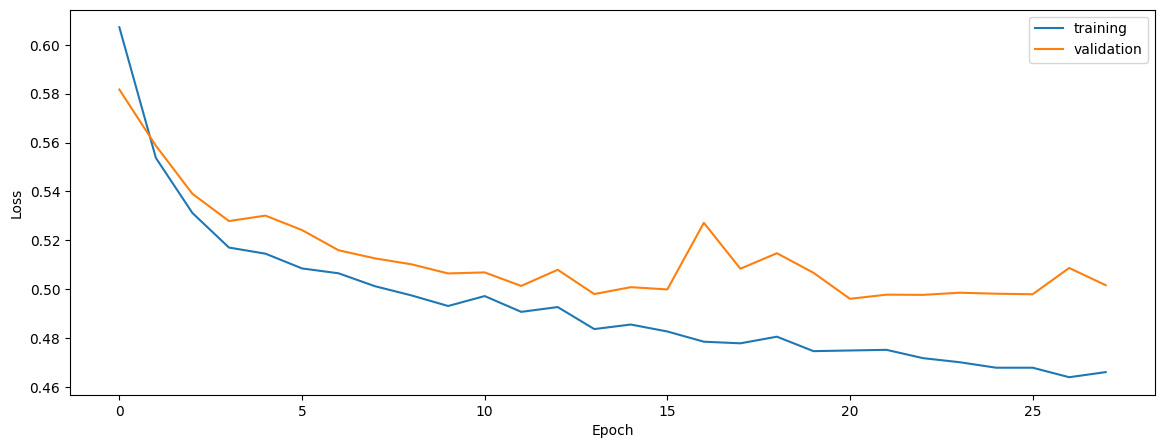

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6481509772037576
0.6225308154235145
0.631937141008009


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6450675344907743
0.6282735274204468
0.6357627625300311


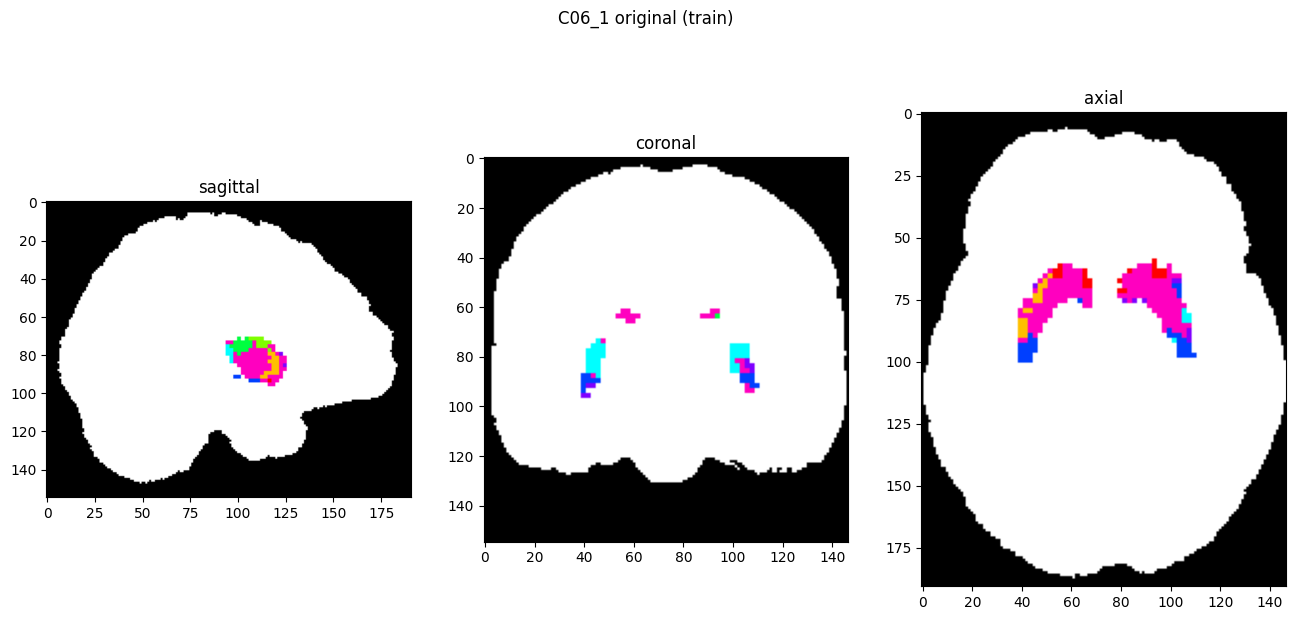

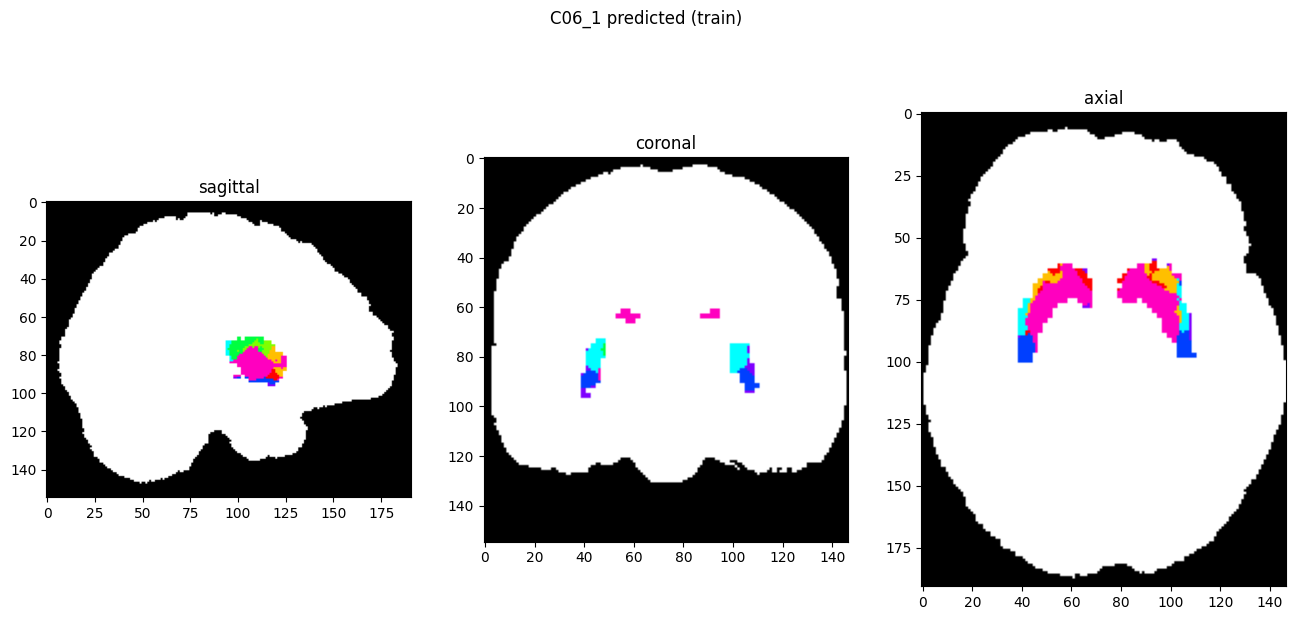

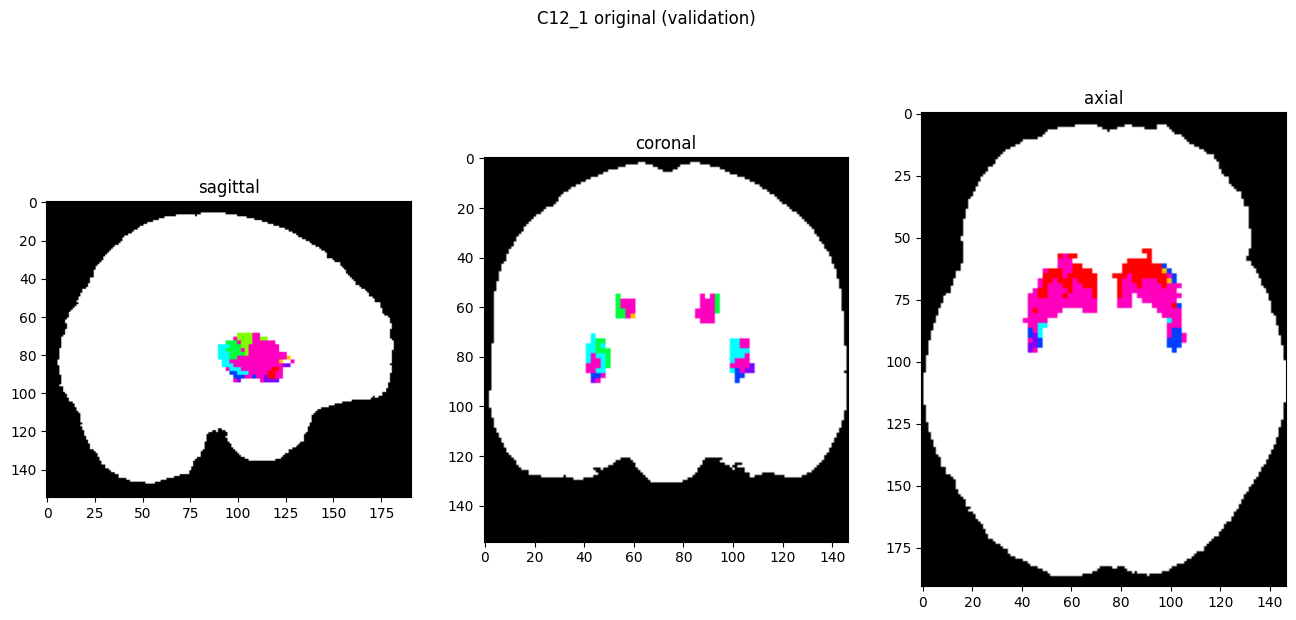

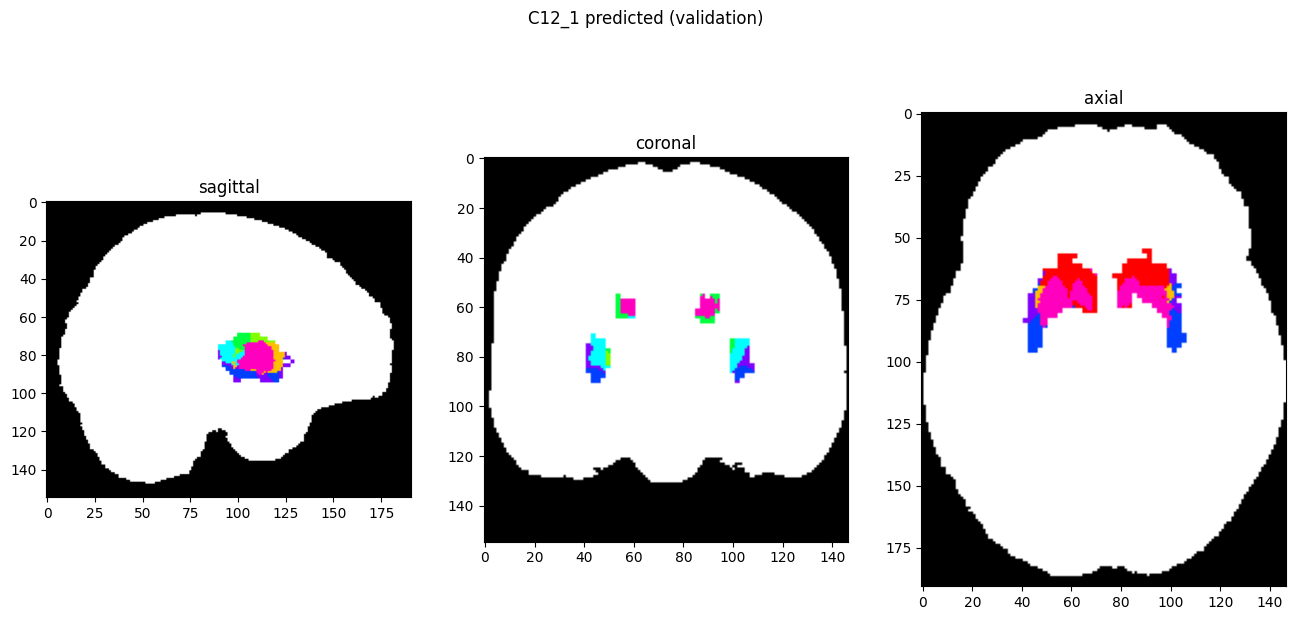

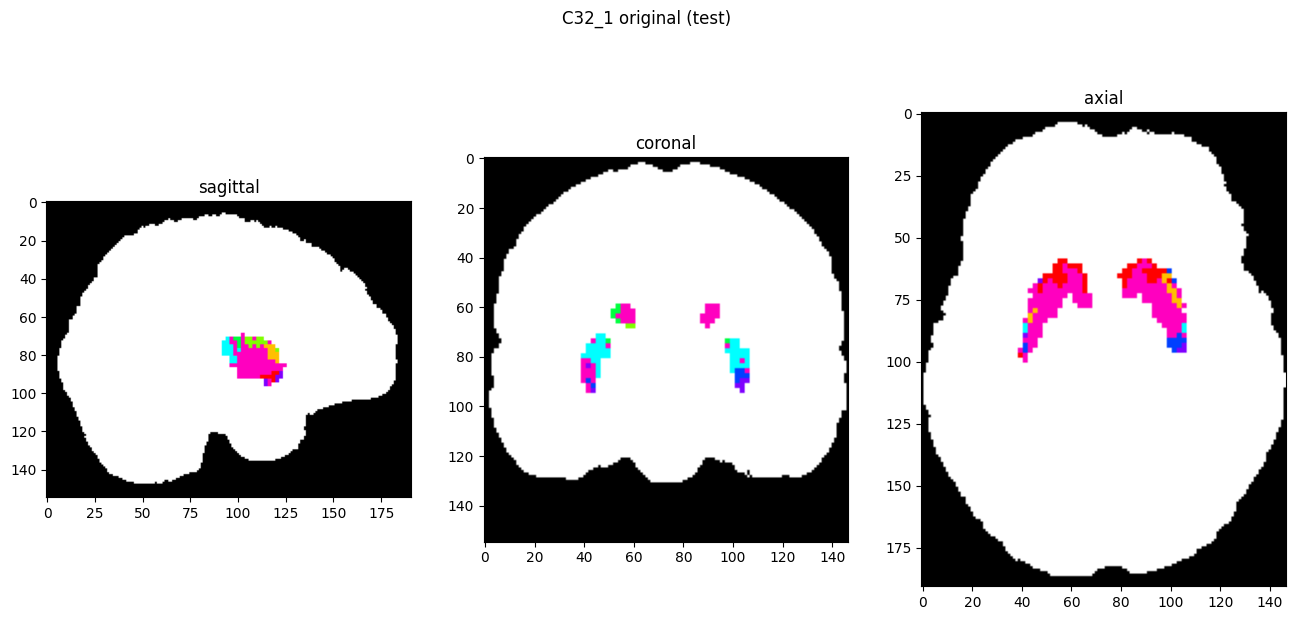

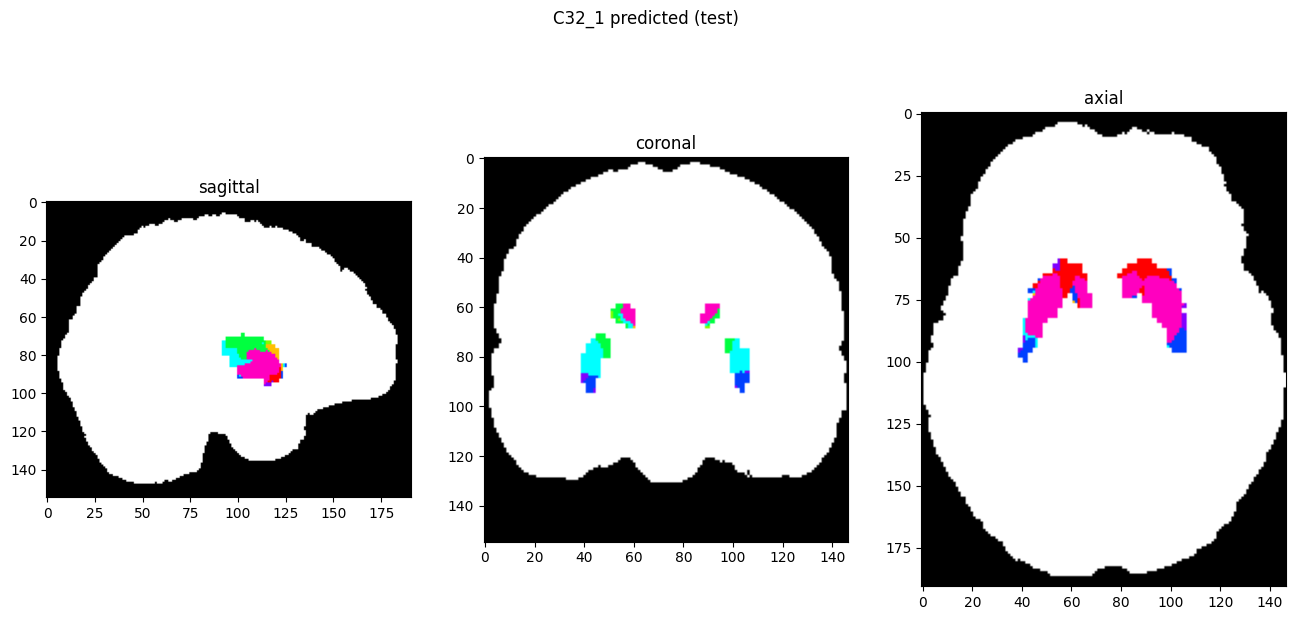

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)